# **NIDIS Capstone Project**
Team B8:
Ting-Hsuan Chen, Risheng Guo, Kratik Gupta, Jiazhi Jia, Maria Stella Vardanega

##**1. Introduction**
**Background**
With the progression of climate change issues that have once been more prevalent in the Western United States like wildfires is quickly becoming a problem in New England as temperatures are rising and droughts are increasing. However, the more moist climate of the New England region has historically made intense wildfires a less common occurrence than on the West Coast. Residents in the New England region thus do not perceive the risk of wildfires. On top of this, because of the socioeconomic barriers, wildfire vulnerability is spread unequally across races and ethnicity. Communities that are mostly black, Hispanic, or Native American experience 50 percent greater vulnerability to wildfires compared with other communities. This is mainly because their neighborhoods are located in low-lying, less-protected areas, and many people lack the resources to evacuate safely. Moreover, their lower-income level makes it especially hard for these communities to recover after a large wildfire (Davies et al., 2018). 

**Goals**

The first goal of this project aims to provide a wildfire severity prediction system that illustrates the severity of wildfires in New England regions as a function of the weather and drought conditions in the previous months. 

Our second goal is to shed light on the difference in the impact that wildfires have on underserved communities when compared to other communities by illustrating the percentage of income that wildfire costs take up for specific counties in the New England region of the United States. 

Finally, we hope to spread more awareness of the disparities between these communities that are prone to wildfires in hopes that municipalities can allocate resources accordingly.



##**2. Hypothesis**
We hypothesize that wildfire costs represent a higher proportion of income for underserved communities compared to more wealthy communities and that this has a detrimental effect on wildfire preparedness and safety.

##**3. Data Collection and Data Cleaning**

###3.1 Data Collection

We first collected the wildfire dataset from the U.S Department of agriculture's forest service research archive. We downloaded and stored the wildfire data via SQLite as a CSV file. The wildfire dataset contains wildfire entries throughout the country, dating from 1992 to 2018. 

Drought data for each county in New England was then obtained from the U.S. Drought Monitor website as a CSV file. The earliest data available was from 2000; therefore, we took drought data for each New England county from 01/01/2000 to 01/01/2020. The drought dataset contains the Drought Severity and Coverage Index(DSCI), which will be used to determine the drought conditions.

After finding these datasets, we looked through census data that would allow us to gain insight into the household income and the demographics of each county as well as the cost of wildfire damage. The census dataset was found through the census.gov website and stored as a CSV file. 


In [1]:
import numpy as np
import pandas as pd
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,f1_score,roc_auc_score, r2_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


####3.1.1 Wildfire Dataset

In [3]:
fire = pd.read_csv("/content/drive/Shareddrives/Capstone_Project/capstone_fire.csv",encoding= 'unicode_escape')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (7,9,10,11,12,13,14,15,16,17,24,25,34,36) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
fire.head(5)

FOD_ID      FPA_ID SOURCE_SYSTEM_TYPE SOURCE_SYSTEM NWCG_REPORTING_AGENCY  \
0       1  FS-1418826                FED   FS-FIRESTAT                    FS   
1       2  FS-1418827                FED   FS-FIRESTAT                    FS   
2       3  FS-1418835                FED   FS-FIRESTAT                    FS   
3       4  FS-1418845                FED   FS-FIRESTAT                    FS   
4       5  FS-1418847                FED   FS-FIRESTAT                    FS   

  NWCG_REPORTING_UNIT_ID  NWCG_REPORTING_UNIT_NAME SOURCE_REPORTING_UNIT  \
0                USCAPNF    Plumas National Forest                   511   
1                USCAENF  Eldorado National Forest                   503   
2                USCAENF  Eldorado National Forest                   503   
3                USCAENF  Eldorado National Forest                   503   
4                USCAENF  Eldorado National Forest                   503   

  SOURCE_REPORTING_UNIT_NAME LOCAL_FIRE_REPORT_ID  ... CONT_TIME FIRE_SIZE  \
0     Plumas National Forest                    1  ...    1730.0      0.10   
1   Eldorado National Forest                   13  ...    1530.0      0.25   
2   Eldorado National Forest                   27  ...    2024.0      0.10   
3   Eldorado National Forest                   43  ...    1400.0      0.10   
4   Eldorado National Forest                   44  ...    1200.0      0.10   

  FIRE_SIZE_CLASS   LATITUDE   LONGITUDE       OWNER_DESCR STATE COUNTY  \
0               A  40.036944 -121.005833              USFS    CA   63.0   
1               A  38.933056 -120.404444              USFS    CA   61.0   
2               A  38.984167 -120.735556  STATE OR PRIVATE    CA   17.0   
3               A  38.559167 -119.913333              USFS    CA    3.0   
4               A  38.559167 -119.933056              USFS    CA    3.0   

   FIPS_CODE         FIPS_NAME  
0     6063.0     Plumas County  
1     6061.0     Placer County  
2     6017.0  El Dorado County  
3     6003.0     Alpine County  
4     6003.0     Alpine County  

[5 rows x 37 columns]

In [5]:
fire.shape

(2166753, 37)

In [6]:
fire.describe()

FOD_ID     FIRE_YEAR  DISCOVERY_DOY  DISCOVERY_TIME  \
count  2.166753e+06  2.166753e+06   2.166753e+06    1.412285e+06   
mean   1.006997e+08  2.005323e+03   1.649900e+02    1.444905e+03   
std    1.503801e+08  7.535558e+00   8.999002e+01    4.247231e+02   
min    1.000000e+00  1.992000e+03   1.000000e+00    0.000000e+00   
25%    5.828420e+05  1.999000e+03   8.900000e+01    1.235000e+03   
50%    1.320811e+06  2.006000e+03   1.650000e+02    1.455000e+03   
75%    2.016622e+08  2.011000e+03   2.300000e+02    1.710000e+03   
max    4.004821e+08  2.018000e+03   3.660000e+02    2.359000e+03   

           CONT_DOY     CONT_TIME     FIRE_SIZE      LATITUDE     LONGITUDE  \
count  1.312200e+06  1.233602e+06  2.166753e+06  2.166753e+06  2.166753e+06   
mean   1.702502e+02  1.523827e+03  7.599040e+01  3.688541e+01 -9.619469e+01   
std    8.637480e+01  4.469547e+02  2.536041e+03  6.019581e+00  1.664964e+01   
min    1.000000e+00  0.000000e+00  1.000000e-05  1.793972e+01 -1.788026e+02   
25%    9.900000e+01  1.305000e+03  1.000000e-01  3.296400e+01 -1.108500e+02   
50%    1.760000e+02  1.555000e+03  9.700000e-01  3.563750e+01 -9.310766e+01   
75%    2.320000e+02  1.810000e+03  3.000000e+00  4.080808e+01 -8.246000e+01   
max    3.660000e+02  2.359000e+03  6.627000e+05  7.033060e+01 -6.525694e+01   

          FIPS_CODE  
count  1.509518e+06  
mean   2.742516e+04  
std    1.690575e+04  
min    1.001000e+03  
25%    1.210700e+04  
50%    2.807700e+04  
75%    4.500300e+04  
max    7.214700e+04

###3.2 Data Cleaning
The dataset we collected had multiple features with null values, the elements unrelated to the fire size, such as the fire name and fire code, etc., so we decided to drop them as it will not affect any predictions. Later, we plotted some correlation matrix to find out how fire size related to different parameters, the ones with almost no correlation were also dropped. After that, we focused on a specific area (New England Region). For that, we made a subset with states in the New England region.

####3.2.1 Wildfire Dataset

In [7]:
fire.isna().sum()

FOD_ID                                 0
FPA_ID                                 0
SOURCE_SYSTEM_TYPE                     0
SOURCE_SYSTEM                          0
NWCG_REPORTING_AGENCY                  0
NWCG_REPORTING_UNIT_ID                 0
NWCG_REPORTING_UNIT_NAME               0
SOURCE_REPORTING_UNIT                  0
SOURCE_REPORTING_UNIT_NAME             0
LOCAL_FIRE_REPORT_ID             1701854
LOCAL_INCIDENT_ID                 734948
FIRE_CODE                        1797127
FIRE_NAME                         960596
ICS_209_PLUS_INCIDENT_JOIN_ID    2135993
ICS_209_PLUS_COMPLEX_JOIN_ID     2165833
MTBS_ID                          2153848
MTBS_FIRE_NAME                   2153848
COMPLEX_NAME                     2161081
FIRE_YEAR                              0
DISCOVERY_DATE                         0
DISCOVERY_DOY                          0
DISCOVERY_TIME                    754468
NWCG_CAUSE_CLASSIFICATION              1
NWCG_GENERAL_CAUSE                     0
NWCG_CAUSE_AGE_C

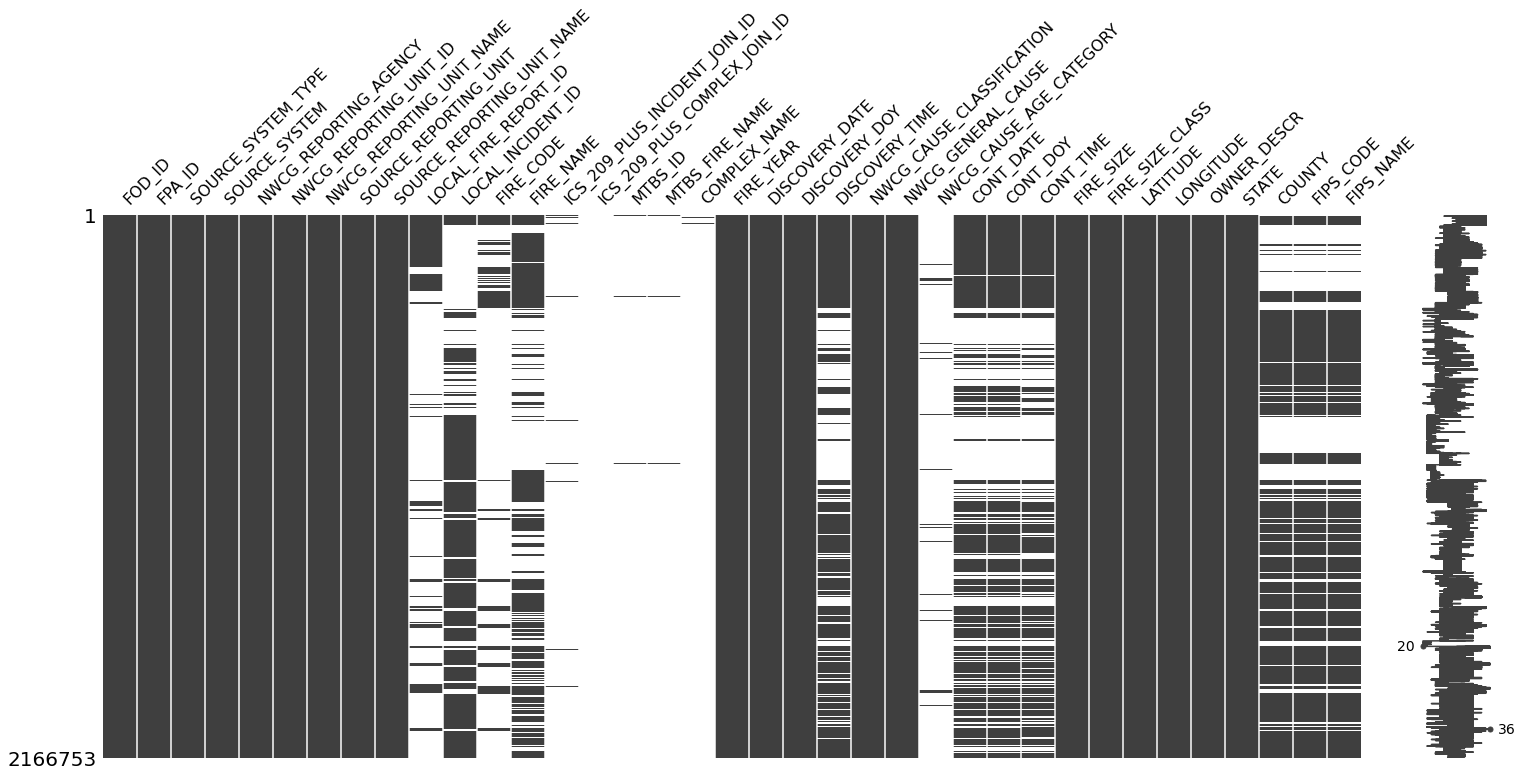

In [8]:
msno.matrix(fire)

In [9]:
#dropping the columns with null values
fire.drop(['LOCAL_FIRE_REPORT_ID','LOCAL_INCIDENT_ID','FIRE_CODE','ICS_209_PLUS_INCIDENT_JOIN_ID','ICS_209_PLUS_COMPLEX_JOIN_ID','MTBS_ID','MTBS_FIRE_NAME','COMPLEX_NAME','NWCG_CAUSE_AGE_CATEGORY'],axis=1, inplace=True)

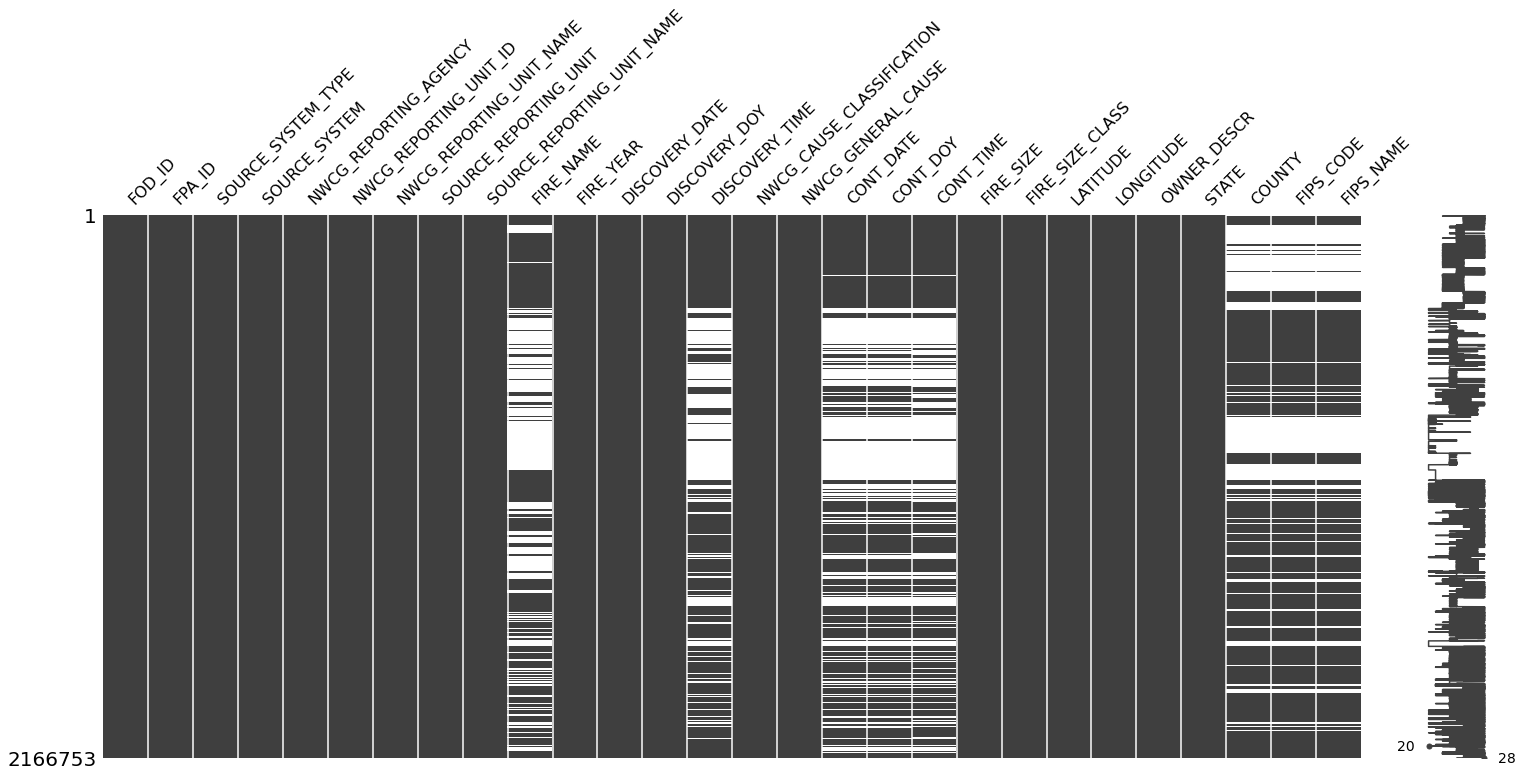

In [10]:
msno.matrix(fire)

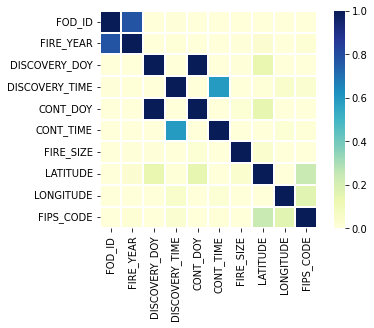

In [11]:
sns.heatmap(fire.corr(),  vmin= 0, vmax=1, linewidths=1, xticklabels=fire.corr().columns, yticklabels=fire.corr().columns, cmap='YlGnBu', square=True);

In [12]:
print(fire['COUNTY'].isna().sum())
#dropping county names as the data is curropted
fire.drop('COUNTY', axis=1, inplace=True)

657235


In [13]:
#as we are focussed on specific area we need county names
# import module for geographical API
from geopy.geocoders import Nominatim
# initialize Nominatim API# initialize Nominatim API
geolocator = Nominatim(user_agent="geoapiExercises")

In [14]:
geolocator.reverse("40.036072228326304" + "," + "-121.0059856304307").raw

{'address': {'ISO3166-2-lvl4': 'US-CA',
  'country': 'United States',
  'country_code': 'us',
  'county': 'Plumas County',
  'hamlet': 'Twain',
  'postcode': '95984',
  'road': 'Feather River Highway',
  'state': 'California'},
 'boundingbox': ['40.01437', '40.0362518', '-121.110398', '-121.0058884'],
 'display_name': 'Feather River Highway, Twain, Plumas County, California, 95984, United States',
 'lat': '40.036074680476744',
 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. https://osm.org/copyright',
 'lon': '-121.00598521300039',
 'osm_id': 992581156,
 'osm_type': 'way',
 'place_id': 320943082}

In [15]:
x = geolocator.reverse("40.036072228326304" + "," + "-121.0059856304307").raw

##**4. Exploratory Data Analysis**


###4.1 Wildfire Dataset

#####4.1.1 Nationwide

In [16]:
fire.FIRE_YEAR.max()

2018

In [17]:
#subsetting the entries with 2000 onwards
fire_2000 = fire[fire['FIRE_YEAR'] >= 2000]

In [18]:
#as day of year will be an important factor, we removed all the null values with DOY as null
fire_2000.drop('FIRE_NAME', axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Because we have a very substantially big dataset, we decided to remove the entries with any relevant null values

In [19]:
fire_2000.dropna(inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


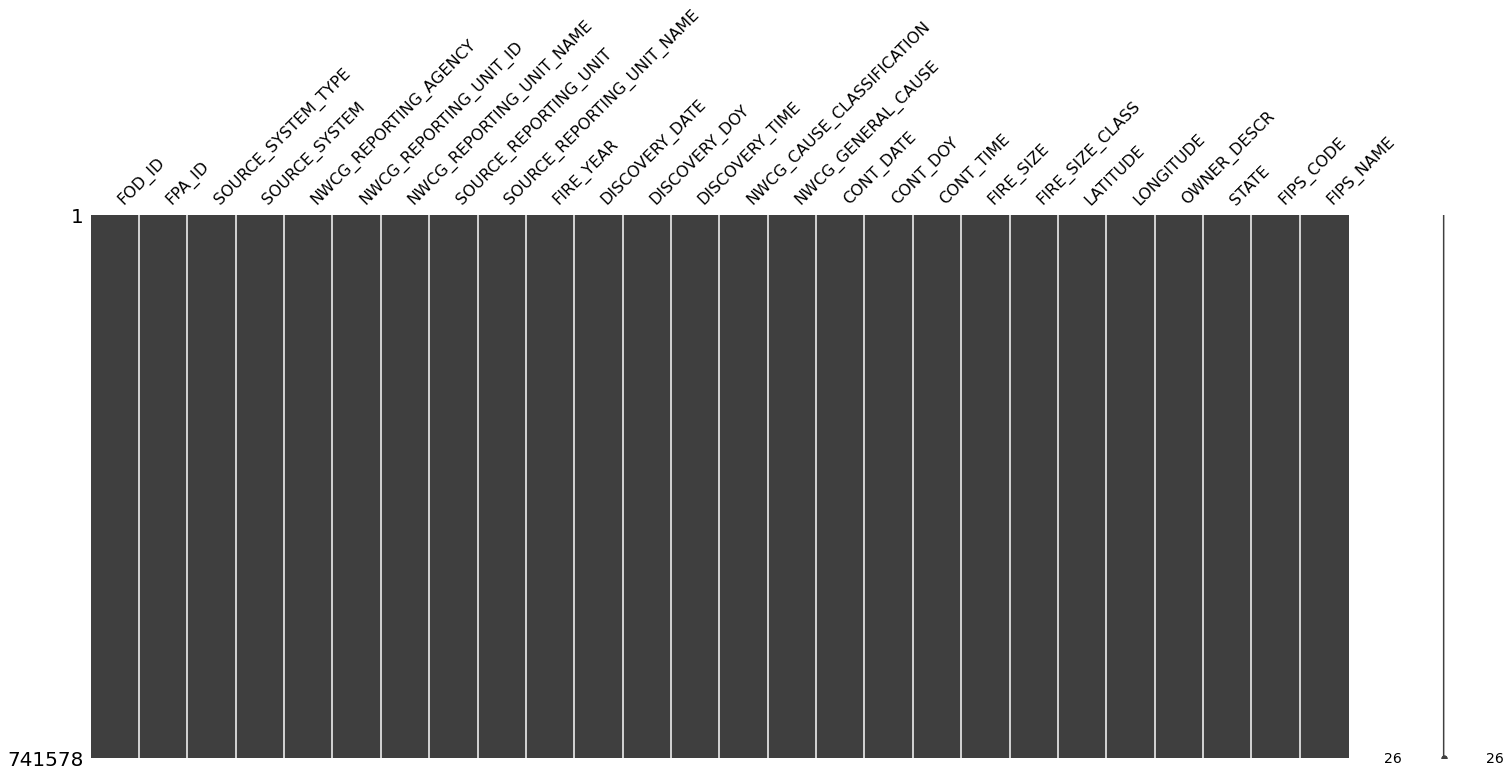

In [20]:
msno.matrix(fire_2000)

In [21]:
fire_2000.shape

(741578, 26)

After exploring the wildfire dataset, we found that from 2000 to 2018, the five states with the most wildfires cases are California(CA), New York(NY), Georgia(GA), Florida(FL), and North Carolina(NC). The five states with the fewest wildfires cases are Hawaii(HI), New Hampshire(NH), Delaware(DE), Vermont(VT), and Iowa(IA).

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


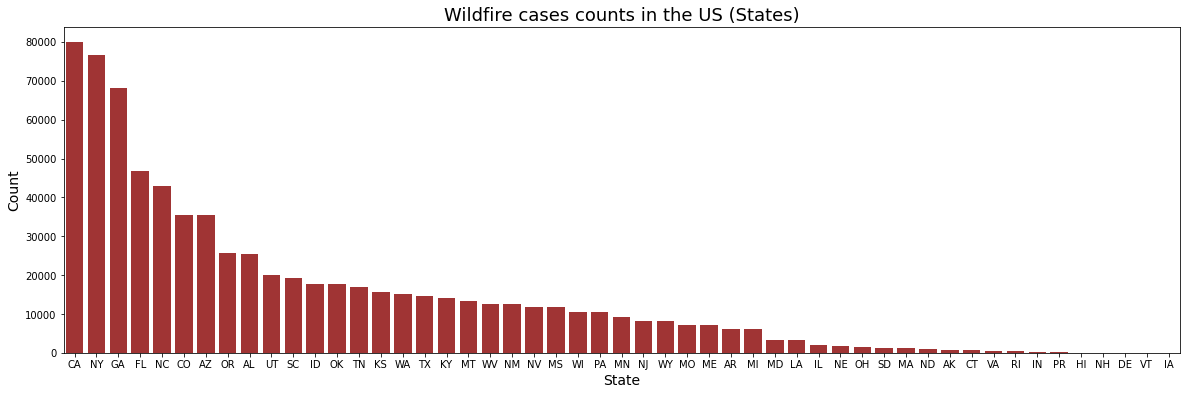

In [22]:
plt.figure(figsize=(20, 6))
sns.countplot(fire_2000.STATE, order = fire_2000.STATE.value_counts().index, color="firebrick")
plt.title('Wildfire cases counts in the US (States)', size = 18)
plt.xlabel('State', size = 14)
plt.ylabel('Count', size = 14)
plt.show()

We found that wildfires mostly occur in autumn and rarely occur in winter.

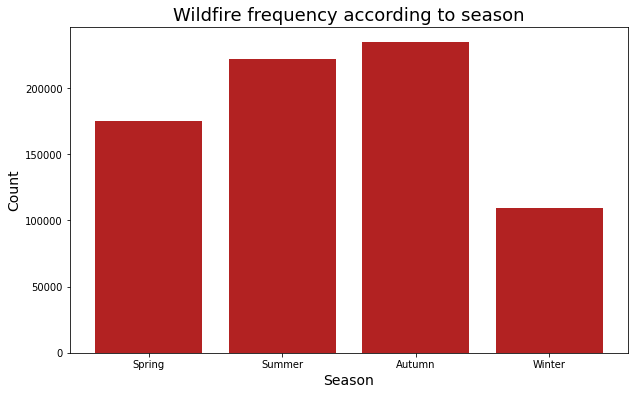

In [23]:
#group by season
plt.figure(figsize=(10, 6))
spring=fire_2000[fire_2000['CONT_DOY']<=90]['FOD_ID'].count()
summer=fire_2000[(fire_2000['CONT_DOY']>90)&(fire_2000['CONT_DOY']<=180)]['FOD_ID'].count()
autumn=fire_2000[(fire_2000['CONT_DOY']>180)&(fire_2000['CONT_DOY']<=270)]['FOD_ID'].count()
winter=fire_2000[fire_2000['CONT_DOY']>270]['FOD_ID'].count()
ls=[spring,summer,autumn,winter]
x=['Spring','Summer','Autumn','Winter']
plt.title('Wildfire frequency according to season', size = 18)
plt.xlabel('Season', size = 14)
plt.ylabel('Count', size = 14)
plt.bar(x,ls, color='firebrick')
plt.show()

Next, we count wildfire cases of a certain fire class between 2000 to 2018. We found that fire incidents across the nation are increasing year by year, proving that this issue is worth noting.

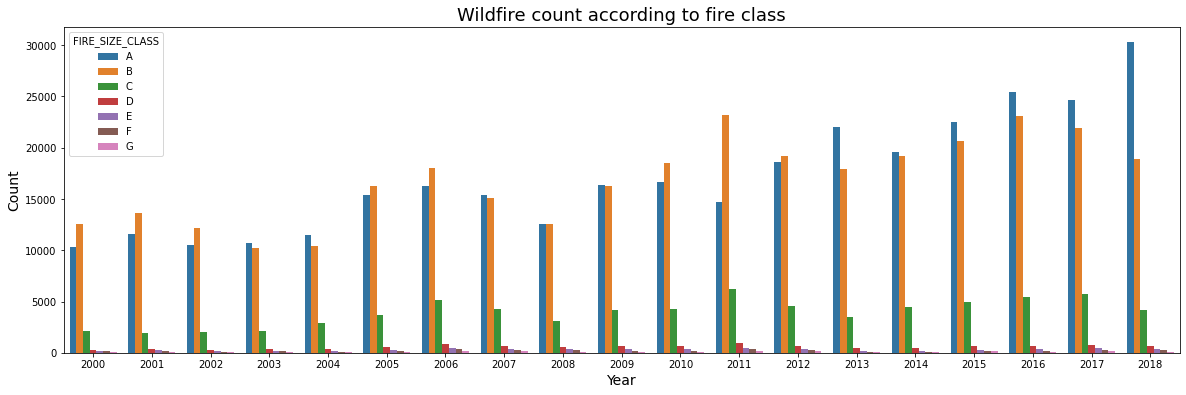

In [24]:
plt.figure(figsize=(20, 6))
sns.countplot(x= fire_2000.FIRE_YEAR, hue=fire_2000.FIRE_SIZE_CLASS.sort_values())
plt.title('Wildfire count according to fire class', size = 18)
plt.xlabel('Year', size = 14)
plt.ylabel('Count', size = 14)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


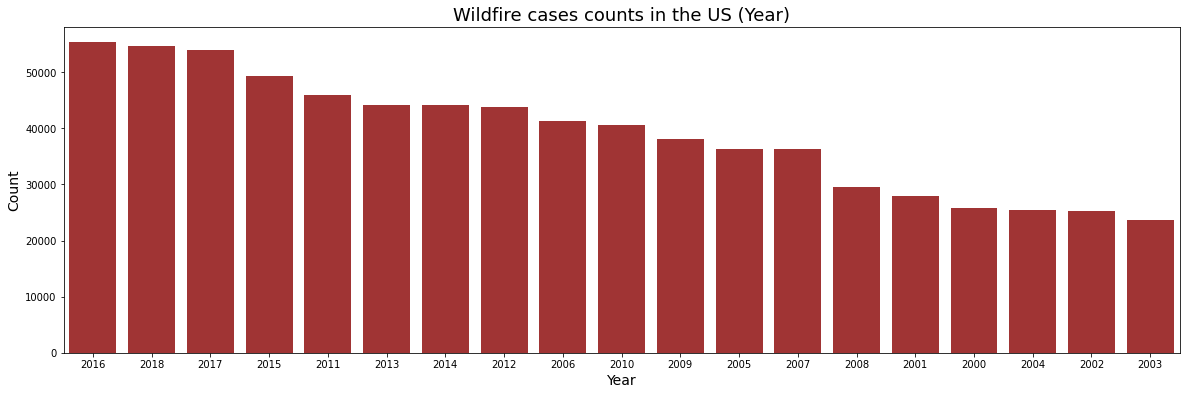

In [25]:
plt.figure(figsize=(20, 6))
sns.countplot(fire_2000.FIRE_YEAR, order = fire_2000.FIRE_YEAR.value_counts().index, color="firebrick")
plt.title('Wildfire cases counts in the US (Year)', size = 18)
plt.xlabel('Year', size = 14)
plt.ylabel('Count', size = 14)
plt.show()

Furthermore, we also noticed that over 580,000 wildfires were caused by humans, but only 133,461 wildfires are natural wildfires.

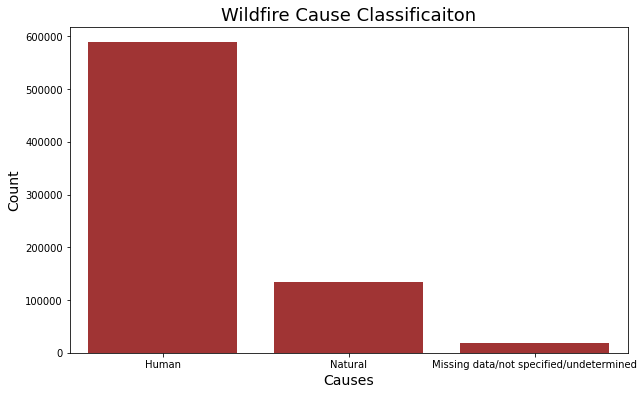

In [26]:
plt.figure(figsize=(10, 6))
sns.countplot(x= fire_2000.NWCG_CAUSE_CLASSIFICATION, order=fire_2000.NWCG_CAUSE_CLASSIFICATION.value_counts().index, color="firebrick")
plt.title('Wildfire Cause Classificaiton', size = 18)
plt.xlabel('Causes', size = 14)
plt.ylabel('Count', size = 14)
plt.show()

In [27]:
sum(fire_2000['NWCG_CAUSE_CLASSIFICATION']=='Human')

589055

In [28]:
sum(fire_2000['NWCG_CAUSE_CLASSIFICATION']=='Natural')

133461

For the general cause of wildfires, we observed that debris and open burning, natural wildfire, and arson/incendiarism cause most of the wildfires incidents in the United States.

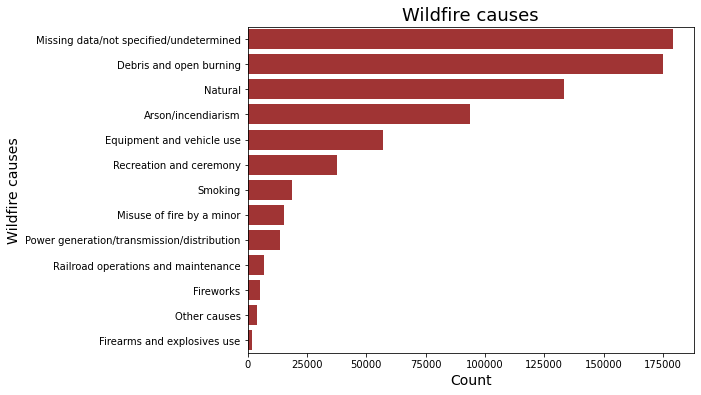

In [29]:
plt.figure(figsize=(8, 6))
sns.countplot(y = fire_2000.NWCG_GENERAL_CAUSE,
              data = fire_2000,
              order = fire_2000['NWCG_GENERAL_CAUSE'].value_counts().index, color='firebrick')
plt.title('Wildfire causes', size = 18)
plt.ylabel('Wildfire causes', size = 14)
plt.xlabel('Count', size = 14)
plt.show()

Lastly, we observed that on average a fire incident was discovered within a day.

In [30]:
#the delay in CONT_DOY and Discovery day of year
(fire_2000['CONT_DOY'] - fire_2000['DISCOVERY_DOY']).mean()

0.8691681792070423

Since Maine, Massachusetts, and Connecticut are the NewEngland states with the most wildfires we focused on those states for our more specific analysis


In [31]:
new_england = fire_2000[fire_2000['STATE'].isin(['CT', 'ME', 'MA', 'NH', 'RI', 'VT'])]

In [32]:
new_england.shape

(9630, 26)

In [33]:
new_england.STATE.unique()

array(['NH', 'ME', 'VT', 'MA', 'CT', 'RI'], dtype=object)

In [34]:
new_england[['STATE']].value_counts()[:100]

STATE
ME       7182
MA       1226
CT        732
RI        425
NH         41
VT         24
dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


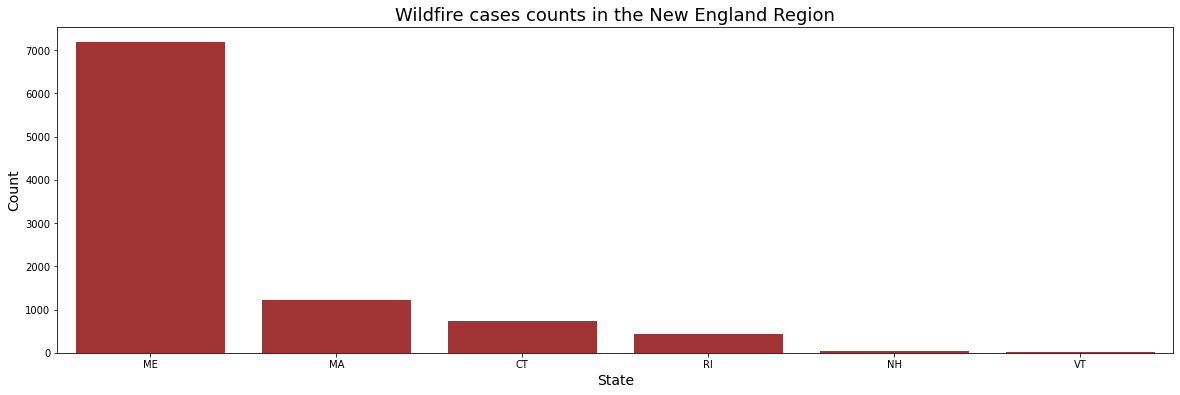

In [35]:
plt.figure(figsize=(20, 6))
sns.countplot(new_england.STATE, order = new_england.STATE.value_counts().index, color="firebrick")
plt.title('Wildfire cases counts in the New England Region', size = 18)
plt.xlabel('State', size = 14)
plt.ylabel('Count', size = 14)
plt.show()

In [36]:
new_england[['FIPS_NAME', 'STATE']].value_counts()[:30]

FIPS_NAME            STATE
Penobscot County     ME       1011
Aroostook County     ME        840
Washington County    ME        679
York County          ME        585
Kennebec County      ME        567
Somerset County      ME        509
Oxford County        ME        503
Hancock County       ME        498
Cumberland County    ME        424
Piscataquis County   ME        409
Essex County         MA        305
Litchfield County    CT        270
Waldo County         ME        258
Franklin County      ME        227
Norfolk County       MA        210
Androscoggin County  ME        205
Worcester County     MA        204
Knox County          ME        199
Providence County    RI        187
Barnstable County    MA        184
Middlesex County     MA        177
Lincoln County       ME        141
Middlesex County     CT        131
Sagadahoc County     ME        127
Kent County          RI        113
Washington County    RI        106
New Haven County     CT        100
Tolland County       CT     

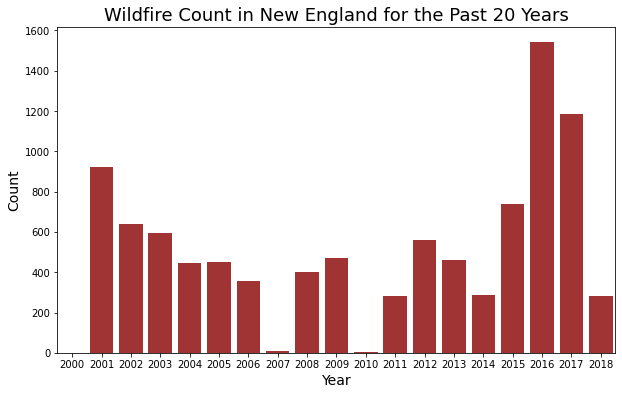

In [37]:
plt.figure(figsize=(10, 6))
sns.countplot(x=new_england.FIRE_YEAR, color='firebrick')
plt.title('Wildfire Count in New England for the Past 20 Years', size = 18)
plt.xlabel('Year', size = 14)
plt.ylabel('Count', size = 14)
plt.show()

####4.1.2 Massachusetts state

In [38]:
#FOR MASSACHUSETTS STATE
fire_ma = fire_2000[fire_2000['STATE'] == 'MA']

In [39]:
fire_ma.head()

FOD_ID                     FPA_ID SOURCE_SYSTEM_TYPE SOURCE_SYSTEM  \
1065424  1300568  ICS209_2008_MA-MAS-000001          INTERAGCY     IA-ICS209   
1065471  1300669  ICS209_2008_MA-MAS-000002          INTERAGCY     IA-ICS209   
1065676  1301006  ICS209_2005_MA-MAS-041605          INTERAGCY     IA-ICS209   
1065710  1301063  ICS209_2004_MA-MAS-000001          INTERAGCY     IA-ICS209   
1065782  1301191   ICS209_2003_MA-MAS-03001          INTERAGCY     IA-ICS209   

        NWCG_REPORTING_AGENCY NWCG_REPORTING_UNIT_ID  \
1065424                ST/C&L                USMAMAS   
1065471                ST/C&L                USMAMAS   
1065676                ST/C&L                USMAMAS   
1065710                ST/C&L                USMAMAS   
1065782                ST/C&L                USMAMAS   

                            NWCG_REPORTING_UNIT_NAME SOURCE_REPORTING_UNIT  \
1065424  Massachusetts Bureau of Forest Fire Control                 MAMAS   
1065471  Massachusetts Bureau of Forest Fire Control                 MAMAS   
1065676  Massachusetts Bureau of Forest Fire Control                 MAMAS   
1065710  Massachusetts Bureau of Forest Fire Control                 MAMAS   
1065782  Massachusetts Bureau of Forest Fire Control                 MAMAS   

                          SOURCE_REPORTING_UNIT_NAME  FIRE_YEAR  ... CONT_DOY  \
1065424  Massachusetts Bureau of Forest Fire Control       2008  ...    115.0   
1065471  Massachusetts Bureau of Forest Fire Control       2008  ...    117.0   
1065676  Massachusetts Bureau of Forest Fire Control       2005  ...    108.0   
1065710  Massachusetts Bureau of Forest Fire Control       2004  ...    121.0   
1065782  Massachusetts Bureau of Forest Fire Control       2003  ...    320.0   

         CONT_TIME  FIRE_SIZE FIRE_SIZE_CLASS   LATITUDE  LONGITUDE  \
1065424     1700.0      130.0               D  42.535556 -73.261944   
1065471      900.0      700.0               E  42.496944 -71.640278   
1065676     1430.0      800.0               E  42.496944 -71.640000   
1065710     1700.0      120.0               D  42.602500 -72.211111   
1065782     1451.0      300.0               E  42.281944 -71.180278   

           OWNER_DESCR  STATE  FIPS_CODE         FIPS_NAME  
1065424        PRIVATE     MA    25003.0  Berkshire County  
1065471  OTHER FEDERAL     MA    25027.0  Worcester County  
1065676          STATE     MA    25027.0  Worcester County  
1065710          STATE     MA    25027.0  Worcester County  
1065782          STATE     MA    25021.0    Norfolk County  

[5 rows x 26 columns]

As we concentrated on Massachusetts fire cases, we noticed that most wildfires incidents occur in recent years, particularly in 2016 and 2017. Among all the wildfire size classes, the majority of wildfire cases are classes A and B.

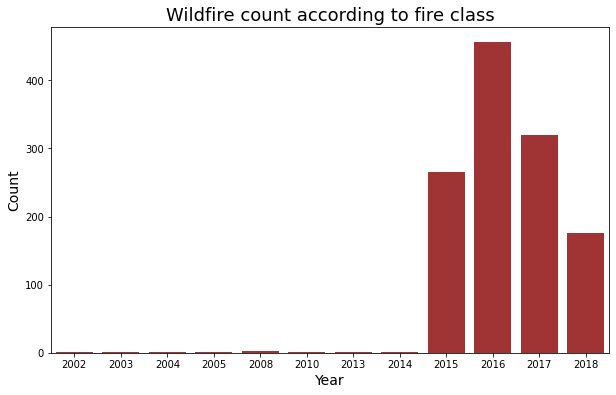

In [40]:
plt.figure(figsize=(10, 6))
sns.countplot(x= fire_ma.FIRE_YEAR, color='firebrick')
plt.title('Wildfire count according to fire class', size = 18)
plt.xlabel('Year', size = 14)
plt.ylabel('Count', size = 14)
plt.show()

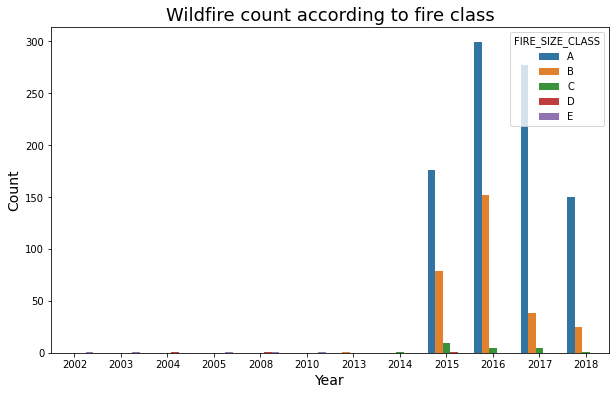

In [41]:
plt.figure(figsize=(10, 6))
sns.countplot(x= fire_ma.FIRE_YEAR, hue=fire_ma.FIRE_SIZE_CLASS.sort_values())
plt.title('Wildfire count according to fire class', size = 18)
plt.xlabel('Year', size = 14)
plt.ylabel('Count', size = 14)
plt.show()

For all the wildfire cases in Massachusetts, 1,186 wildfire cases were caused by humans and 37 wildfires are natural wildfires.

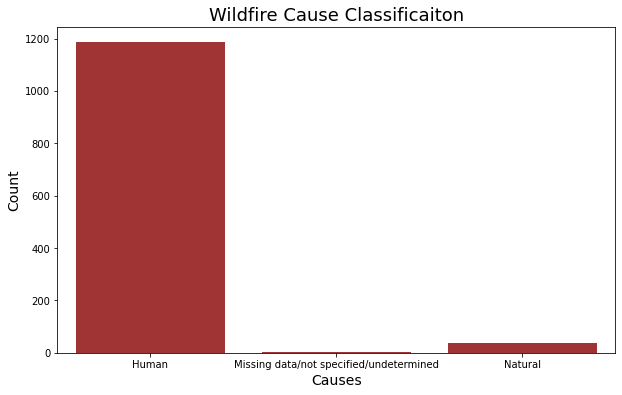

In [42]:
plt.figure(figsize=(10, 6))
sns.countplot(x= fire_ma.NWCG_CAUSE_CLASSIFICATION.sort_values(), color="firebrick")
plt.title('Wildfire Cause Classificaiton', size = 18)
plt.xlabel('Causes', size = 14)
plt.ylabel('Count', size = 14)
plt.show()

In [43]:
sum(fire_ma['NWCG_CAUSE_CLASSIFICATION']=='Human')

1186

In [44]:
sum(fire_ma['NWCG_CAUSE_CLASSIFICATION']=='Natural')

37

For the general cause of wildfires, we observed that debris and open burning, recreation and ceremony, and smoking cause most of the wildfires incidents in Massachusetts. 

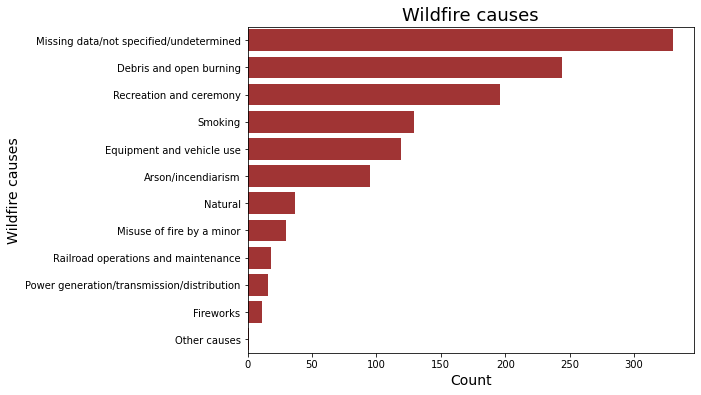

In [45]:
plt.figure(figsize=(8, 6))
sns.countplot(y = fire_ma.NWCG_GENERAL_CAUSE,
              data = fire_ma,
              order = fire_ma['NWCG_GENERAL_CAUSE'].value_counts().index, color='firebrick')
plt.title('Wildfire causes', size = 18)
plt.ylabel('Wildfire causes', size = 14)
plt.xlabel('Count', size = 14)
plt.show()

We also observed that Berkshire County, Hampden County, Worcester County, Barnstable County, Essex County, Dukes County, Suffolk County, Middlesex County, Hampshire County, and Norfolk County had wildfires from 2000 to 2018. Among those counties, Essex County has the most wildfire incidents

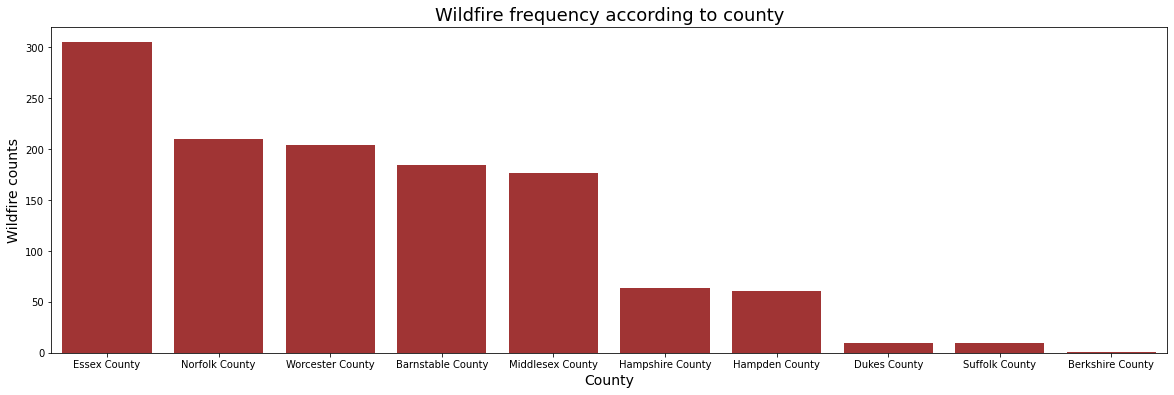

In [46]:
plt.figure(figsize=(20, 6))
sns.countplot(x = fire_ma.FIPS_NAME,
              data = fire_ma,
              order = fire_ma['FIPS_NAME'].value_counts().index, color="firebrick")
plt.title('Wildfire frequency according to county', size = 18)
plt.ylabel('Wildfire counts', size = 14)
plt.xlabel('County', size = 14)
plt.show()

####4.1.3 Maine state

In [47]:
#FOR Maine STATE
fire_me = fire_2000[fire_2000['STATE'] == 'ME']

After conducting some preliminary analysis we found that the years with the most wildfires in the state of Maine were 2001 and 2016 with 963 and 658 wildfires respectively. The most common fire size class was Class A, which was closely followed by Class B.

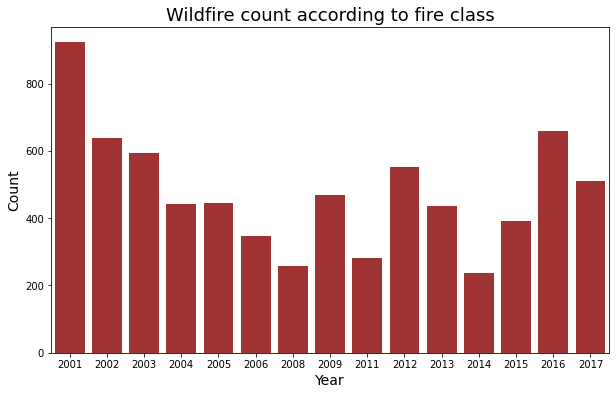

In [48]:
plt.figure(figsize=(10, 6))
sns.countplot(x= fire_me.FIRE_YEAR, color='firebrick')
plt.title('Wildfire count according to fire class', size = 18)
plt.xlabel('Year', size = 14)
plt.ylabel('Count', size = 14)
plt.show()

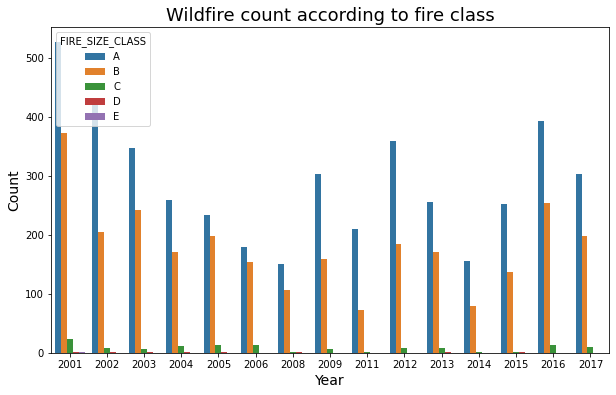

In [49]:
plt.figure(figsize=(10, 6))
sns.countplot(x=fire_me.FIRE_YEAR, hue=fire_me.FIRE_SIZE_CLASS.sort_values())
plt.title('Wildfire count according to fire class', size = 18)
plt.xlabel('Year', size = 14)
plt.ylabel('Count', size = 14)
plt.show()

In [50]:
fire_me.FIRE_YEAR.value_counts().sort_values()

2014    237
2008    258
2011    283
2006    347
2015    391
2013    435
2004    443
2005    446
2009    469
2017    509
2012    551
2003    594
2002    638
2016    658
2001    923
Name: FIRE_YEAR, dtype: int64


For the general cause of wildfires, we observed that debris and open burning and equipment and vehicle use cause most of the wildfires incidents in Maine.

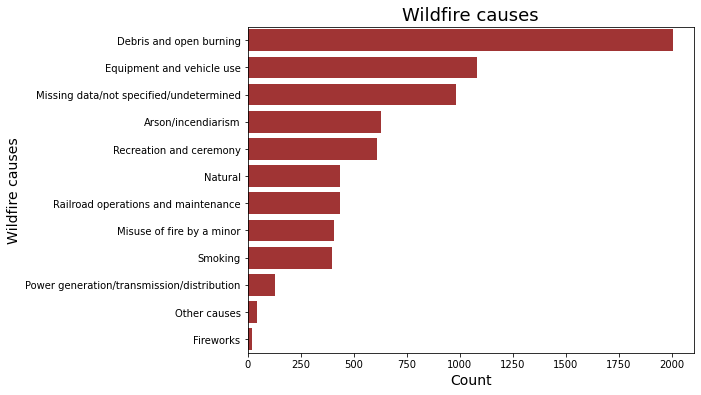

In [51]:
plt.figure(figsize=(8, 6))
sns.countplot(y = fire_me.NWCG_GENERAL_CAUSE,
              data = fire_me,
              order = fire_me['NWCG_GENERAL_CAUSE'].value_counts().index,color='firebrick')
plt.title('Wildfire causes', size = 18)
plt.ylabel('Wildfire causes', size = 14)
plt.xlabel('Count', size = 14)
plt.show()

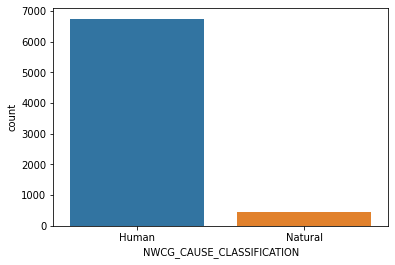

In [52]:
sns.countplot(x= fire_me.NWCG_CAUSE_CLASSIFICATION.sort_values())

The counties in Maine that experienced the most wildfires since 2000 were Penobscot County and Aroostook County.

In [53]:
new_england[['FIPS_NAME', 'STATE']].value_counts()[:10]

FIPS_NAME           STATE
Penobscot County    ME       1011
Aroostook County    ME        840
Washington County   ME        679
York County         ME        585
Kennebec County     ME        567
Somerset County     ME        509
Oxford County       ME        503
Hancock County      ME        498
Cumberland County   ME        424
Piscataquis County  ME        409
dtype: int64

####4.1.4 Connecticut state




In [54]:
#FOR Connecticut STATE
fire_ct = fire_2000[fire_2000['STATE'] == 'CT']

Connecticut displays similar patterns as Massachusetts . To begin with, we noticed that most wildfires incidents occur in recent years, particularly in 2016 and 2017. In Connecticut, the most common fire class was Class A, similar to both MA and ME.

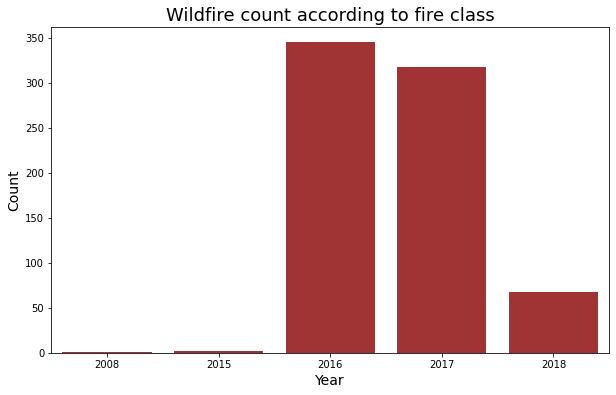

In [55]:
plt.figure(figsize=(10, 6))
sns.countplot(x= fire_ct.FIRE_YEAR, color='firebrick')
plt.title('Wildfire count according to fire class', size = 18)
plt.xlabel('Year', size = 14)
plt.ylabel('Count', size = 14)
plt.show()

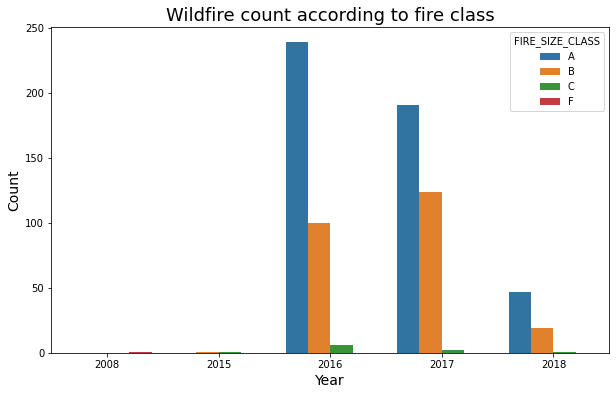

In [56]:
plt.figure(figsize=(10, 6))
sns.countplot(x= fire_ct.FIRE_YEAR, hue=fire_ct.FIRE_SIZE_CLASS.sort_values())
plt.title('Wildfire count according to fire class', size = 18)
plt.xlabel('Year', size = 14)
plt.ylabel('Count', size = 14)
plt.show()

Furthermore, the most common causes of the fire that are portrayed in the data set are debris and open burning, which make up the vast majority of causes, followed by recreation and ceremony.

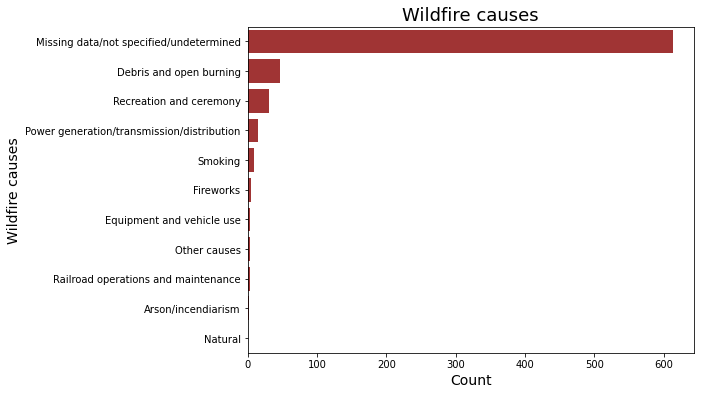

In [57]:
plt.figure(figsize=(8, 6))
sns.countplot(y = fire_ct.NWCG_GENERAL_CAUSE,
              data = fire_ct,
              order = fire_ct['NWCG_GENERAL_CAUSE'].value_counts().index,color='firebrick')
plt.title('Wildfire causes', size = 18)
plt.ylabel('Wildfire causes', size = 14)
plt.xlabel('Count', size = 14)
plt.show()

Furthermore, the top county that experienced the most wildfires in CT was Litchfield County.

In [58]:
fire_ct.groupby(['FIPS_NAME']).size().sort_values()

FIPS_NAME
Hartford County       27
Windham County        27
Fairfield County      34
New London County     48
Tolland County        95
New Haven County     100
Middlesex County     131
Litchfield County    270
dtype: int64

###4.2 Drought Dataset

For the drought dataset, we took drought data for each county in the New England region from 01/01/2000 to 01/01/2020. 

####4.2.1 DSCI
The drought dataset contains the Drought Severity and Coverage Index(DSCI). The DSCI is an index for converting drought levels from the U.S. Drought Monitor map to a single value for an area. DSCI values are part of the U.S. Drought Monitor data tables. Possible values of the DSCI are from 0 to 500. Zero means that none of the areas is abnormally dry or in drought, and 500 means that all of the areas are in D4, exceptional drought. 

In [59]:
drought = pd.read_csv("/content/drive/Shareddrives/Capstone_Project/drought_new_england_weekly.csv")

In [60]:
drought.head(5)

State            County  FIPS   MapDate  DSCI
0    CT  Fairfield County  9001  20000104     0
1    CT  Fairfield County  9001  20000111     0
2    CT  Fairfield County  9001  20000118     0
3    CT  Fairfield County  9001  20000125     0
4    CT  Fairfield County  9001  20000201     0

In [61]:
drought.shape

(69948, 5)

In [62]:
drought['County'].unique()

array(['Fairfield County', 'Hartford County', 'Litchfield County',
       'Middlesex County', 'New Haven County', 'New London County',
       'Tolland County', 'Windham County', 'Barnstable County',
       'Berkshire County', 'Bristol County', 'Dukes County',
       'Essex County', 'Franklin County', 'Hampden County',
       'Hampshire County', 'Nantucket County', 'Norfolk County',
       'Plymouth County', 'Suffolk County', 'Worcester County',
       'Androscoggin County', 'Aroostook County', 'Cumberland County',
       'Hancock County', 'Kennebec County', 'Knox County',
       'Lincoln County', 'Oxford County', 'Penobscot County',
       'Piscataquis County', 'Sagadahoc County', 'Somerset County',
       'Waldo County', 'Washington County', 'York County',
       'Belknap County', 'Carroll County', 'Cheshire County',
       'Coos County', 'Grafton County', 'Hillsborough County',
       'Merrimack County', 'Rockingham County', 'Strafford County',
       'Sullivan County', 'Kent County'

In [63]:
drought['State'].unique()

array(['CT', 'MA', 'ME', 'NH', 'RI', 'VT'], dtype=object)

In [64]:
#formatting the datetime
drought['MapDate'] = pd.to_datetime(drought['MapDate'], format='%Y%m%d')

We first calculated the average DSCI in Massachusetts,  Maine, and Connecticut for the past 10 years. We observed that the average DSCI in these three states displays a similar pattern. These three states all relatively have high DSCI values in 2001, 2002, 2016, and, 2017.

In [65]:
drought_ma = drought[drought['State'] == 'MA']
drought_me = drought[drought['State'] == 'ME']
drought_ct = drought[drought['State'] == 'CT']

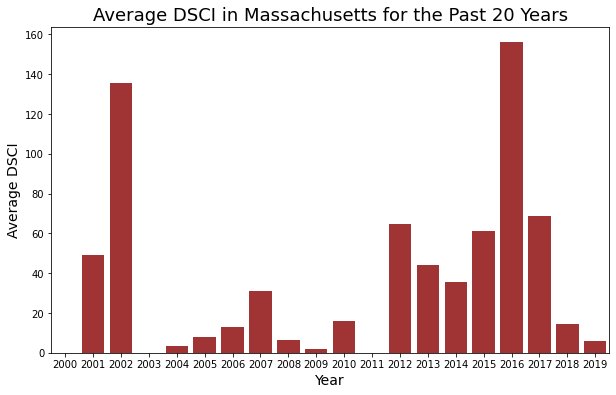

In [66]:
plt.figure(figsize=(10, 6))
sns.barplot(y=drought_ma.groupby(pd.DatetimeIndex(drought_ma['MapDate']).year)['DSCI'].mean(), x=pd.DatetimeIndex(drought_ma['MapDate']).year.unique(), color='firebrick')
plt.title('Average DSCI in Massachusetts for the Past 20 Years', size = 18)
plt.xlabel('Year', size = 14)
plt.ylabel('Average DSCI', size = 14)
plt.show()

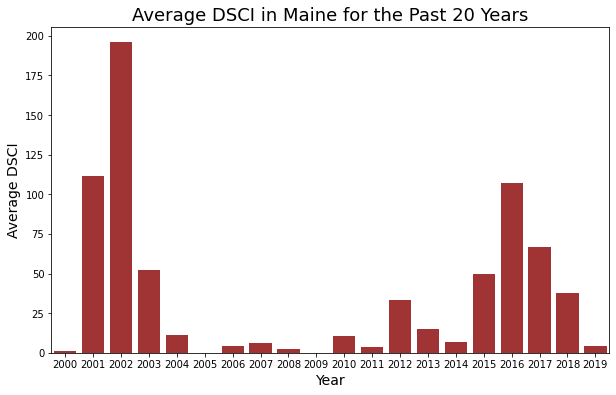

In [67]:
plt.figure(figsize=(10, 6))
sns.barplot(y=drought_me.groupby(pd.DatetimeIndex(drought_me['MapDate']).year)['DSCI'].mean(), x=pd.DatetimeIndex(drought_me['MapDate']).year.unique(), color='firebrick')
plt.title('Average DSCI in Maine for the Past 20 Years', size = 18)
plt.xlabel('Year', size = 14)
plt.ylabel('Average DSCI', size = 14)
plt.show()

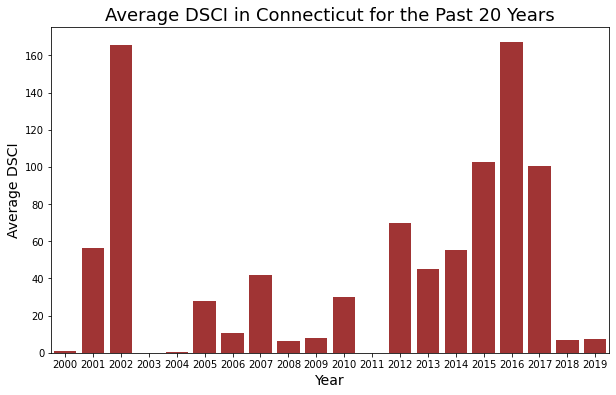

In [68]:
plt.figure(figsize=(10, 6))
sns.barplot(y=drought_ct.groupby(pd.DatetimeIndex(drought_ct['MapDate']).year)['DSCI'].mean(), x=pd.DatetimeIndex(drought_ct['MapDate']).year.unique(), color='firebrick')
plt.title('Average DSCI in Connecticut for the Past 20 Years', size = 18)
plt.xlabel('Year', size = 14)
plt.ylabel('Average DSCI', size = 14)
plt.show()

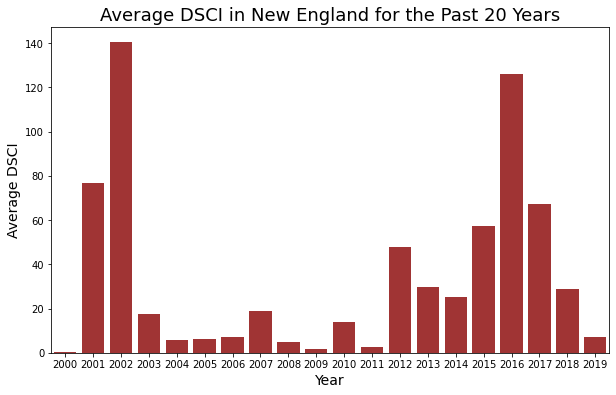

In [69]:
plt.figure(figsize=(10, 6))
sns.barplot(y=drought.groupby(pd.DatetimeIndex(drought['MapDate']).year)['DSCI'].mean(), x=pd.DatetimeIndex(drought['MapDate']).year.unique(), color='firebrick')
plt.title('Average DSCI in New England for the Past 20 Years', size = 18)
plt.xlabel('Year', size = 14)
plt.ylabel('Average DSCI', size = 14)
plt.show()

We calculated the average DSCI according to the county. We found out that York County and Plymouth County have the highest average DSCI in New England region.

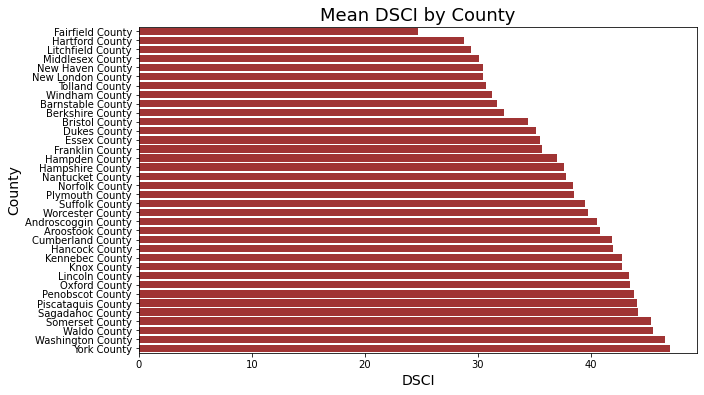

In [70]:
plt.figure(figsize=(10, 6))
sns.barplot(x = drought[drought['State'].isin(['CT', 'MA', 'ME'])].groupby(['County'])['DSCI'].mean().sort_values(), y = drought[drought['State'].isin(['CT', 'MA', 'ME'])]['County'].unique(),color='firebrick')
plt.title('Mean DSCI by County', size = 18)
plt.ylabel('County', size = 14)
plt.xlabel('DSCI', size = 14)
plt.show()

We then plotted the DSCI of York County and Plymouth County according to the year. We noticed that similar to the average DSCI of three states, these two counties share the same trends in terms of DSCI.

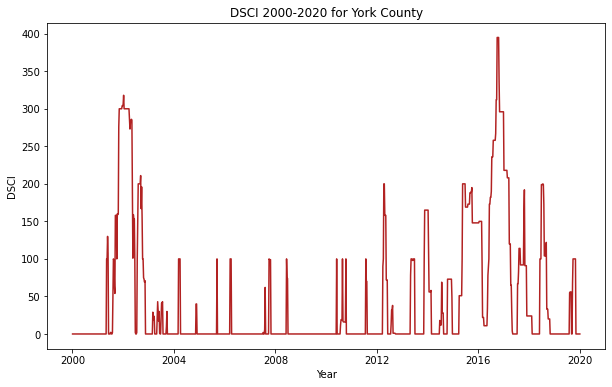

In [71]:
plt.figure(figsize=(10, 6))
sns.lineplot(color='firebrick',x = "MapDate", y = "DSCI",
             data = drought[drought['County'] == 'York County']).set(title='DSCI 2000-2020 for York County')
plt.xlabel('Year', size = 10)
plt.ylabel('DSCI', size = 10)
plt.show()

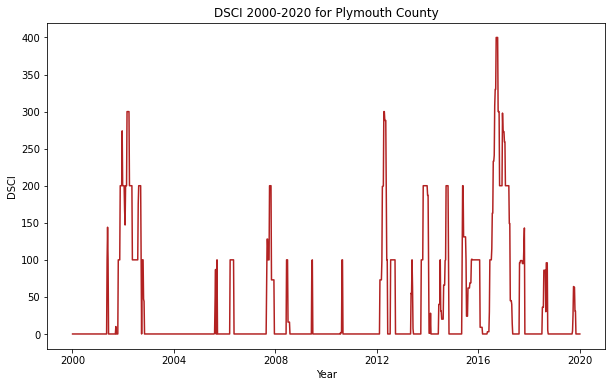

In [72]:
plt.figure(figsize=(10, 6))
sns.lineplot(color='firebrick',x = "MapDate", y = "DSCI",
             data = drought[drought['County'] == 'Plymouth County']).set(title='DSCI 2000-2020 for Plymouth County')
plt.xlabel('Year', size = 10)
plt.ylabel('DSCI', size = 10)
plt.show()

The average DSCI value in Massachusetts, Maine, and Connecticut are 39.2, 35.05, and 44.14 respectively.

In [73]:
drought[drought['State'].isin(['CT', 'MA', 'ME'])].groupby(['State'])['DSCI'].mean()

State
CT    45.194085
MA    35.786604
ME    36.161578
Name: DSCI, dtype: float64

##**5. Merging the Datasets for ML**

Our feature engineering encompassed merging the wildfire and drought datasets together in a meaningful way for machine learning use. The base table we used was the wildfire dataset as the goal of our machine learning model was to predict the severity of wildfires in the New England region. Therefore, we needed to merge the two datasets in a way that for every date for which a wildfire occurred in a specific county there was a respective DSCI value associated with the row. We firstly confirmed that both datasets contained the same counties as these along with the dates would be the metrics we’d be joining the tables on. Next, we created a function that was able to calculate the average DSCI score of the previous n weeks (Section 5.3). Finally, we merged the dataset by matching the state, county, and date of each dataset and appending 3 separate columns with averages of the previous 4, 8, and 12 weeks. The final dataset included the original wildfire dataset columns with an additional 3 DSCI average columns.

###5.1 Formatting the Wildfire dataset

In [74]:
## Creating ML Dataset
new_england.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9630 entries, 5810 to 2166698
Data columns (total 26 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   FOD_ID                      9630 non-null   int64  
 1   FPA_ID                      9630 non-null   object 
 2   SOURCE_SYSTEM_TYPE          9630 non-null   object 
 3   SOURCE_SYSTEM               9630 non-null   object 
 4   NWCG_REPORTING_AGENCY       9630 non-null   object 
 5   NWCG_REPORTING_UNIT_ID      9630 non-null   object 
 6   NWCG_REPORTING_UNIT_NAME    9630 non-null   object 
 7   SOURCE_REPORTING_UNIT       9630 non-null   object 
 8   SOURCE_REPORTING_UNIT_NAME  9630 non-null   object 
 9   FIRE_YEAR                   9630 non-null   int64  
 10  DISCOVERY_DATE              9630 non-null   object 
 11  DISCOVERY_DOY               9630 non-null   int64  
 12  DISCOVERY_TIME              9630 non-null   float64
 13  NWCG_CAUSE_CLASSIFICATION  

In [75]:
new_england.isna().sum()

FOD_ID                        0
FPA_ID                        0
SOURCE_SYSTEM_TYPE            0
SOURCE_SYSTEM                 0
NWCG_REPORTING_AGENCY         0
NWCG_REPORTING_UNIT_ID        0
NWCG_REPORTING_UNIT_NAME      0
SOURCE_REPORTING_UNIT         0
SOURCE_REPORTING_UNIT_NAME    0
FIRE_YEAR                     0
DISCOVERY_DATE                0
DISCOVERY_DOY                 0
DISCOVERY_TIME                0
NWCG_CAUSE_CLASSIFICATION     0
NWCG_GENERAL_CAUSE            0
CONT_DATE                     0
CONT_DOY                      0
CONT_TIME                     0
FIRE_SIZE                     0
FIRE_SIZE_CLASS               0
LATITUDE                      0
LONGITUDE                     0
OWNER_DESCR                   0
STATE                         0
FIPS_CODE                     0
FIPS_NAME                     0
dtype: int64

In [76]:
# #Dropping rows that have missing dates
# new_england = new_england[new_england['CONT_DATE'].notna()]
# new_england = new_england[new_england['FIPS_NAME'].notna()]
# new_england.isna().sum()

In [77]:
new_england['CONT_DATE'] = pd.to_datetime(new_england['CONT_DATE'], format='%m/%d/%Y %H:%M')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [78]:
new_england['CONT_DATE']

5810      2005-05-11
15213     2006-04-22
16022     2006-04-19
16061     2006-07-10
16471     2006-04-30
             ...    
2166694   2018-11-17
2166695   2018-12-12
2166696   2018-04-16
2166697   2018-04-23
2166698   2018-11-09
Name: CONT_DATE, Length: 9630, dtype: datetime64[ns]

In [79]:
len(new_england['FIPS_NAME'].unique())

44

In [80]:
new_england['FIPS_NAME'].unique()

array(['Carroll County', 'Coos County', 'Oxford County',
       'Bennington County', 'Addison County', 'Rutland County',
       'Grafton County', 'Windham County', 'Hancock County',
       'Washington County', 'Penobscot County', 'Knox County',
       'Piscataquis County', 'Somerset County', 'York County',
       'Cumberland County', 'Androscoggin County', 'Sagadahoc County',
       'Kennebec County', 'Franklin County', 'Lincoln County',
       'Waldo County', 'Aroostook County', 'Windsor County',
       'Berkshire County', 'Worcester County', 'Norfolk County',
       'Hampden County', 'Litchfield County', 'Providence County',
       'Kent County', 'Newport County', 'Bristol County',
       'Barnstable County', 'Essex County', 'Dukes County',
       'Middlesex County', 'Suffolk County', 'New London County',
       'Hampshire County', 'Tolland County', 'Fairfield County',
       'Hartford County', 'New Haven County'], dtype=object)

In [81]:
new_england['STATE'].unique()

array(['NH', 'ME', 'VT', 'MA', 'CT', 'RI'], dtype=object)

In [82]:
new_england.sort_values('CONT_DATE', inplace = True, axis = 0)
new_england['CONT_DATE']

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


131080    2000-07-14
688491    2001-04-07
687368    2001-04-11
687528    2001-04-11
687677    2001-04-14
             ...    
2069225   2018-12-27
2087964   2018-12-27
2087960   2018-12-27
2160898   2018-12-31
2109169   2019-04-09
Name: CONT_DATE, Length: 9630, dtype: datetime64[ns]

###5.2 Formatting the drought dataset

In [83]:
len(drought['County'].unique())

59

In [84]:
drought['County'].unique()

array(['Fairfield County', 'Hartford County', 'Litchfield County',
       'Middlesex County', 'New Haven County', 'New London County',
       'Tolland County', 'Windham County', 'Barnstable County',
       'Berkshire County', 'Bristol County', 'Dukes County',
       'Essex County', 'Franklin County', 'Hampden County',
       'Hampshire County', 'Nantucket County', 'Norfolk County',
       'Plymouth County', 'Suffolk County', 'Worcester County',
       'Androscoggin County', 'Aroostook County', 'Cumberland County',
       'Hancock County', 'Kennebec County', 'Knox County',
       'Lincoln County', 'Oxford County', 'Penobscot County',
       'Piscataquis County', 'Sagadahoc County', 'Somerset County',
       'Waldo County', 'Washington County', 'York County',
       'Belknap County', 'Carroll County', 'Cheshire County',
       'Coos County', 'Grafton County', 'Hillsborough County',
       'Merrimack County', 'Rockingham County', 'Strafford County',
       'Sullivan County', 'Kent County'

In [85]:
drought.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69948 entries, 0 to 69947
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   State    69948 non-null  object        
 1   County   69948 non-null  object        
 2   FIPS     69948 non-null  int64         
 3   MapDate  69948 non-null  datetime64[ns]
 4   DSCI     69948 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 2.7+ MB


In [86]:
drought['State'].unique()

array(['CT', 'MA', 'ME', 'NH', 'RI', 'VT'], dtype=object)

In [87]:
drought['MapDate'] = pd.to_datetime(drought['MapDate'], format='%Y%m%d')

In [88]:
drought.head()

State            County  FIPS    MapDate  DSCI
0    CT  Fairfield County  9001 2000-01-04     0
1    CT  Fairfield County  9001 2000-01-11     0
2    CT  Fairfield County  9001 2000-01-18     0
3    CT  Fairfield County  9001 2000-01-25     0
4    CT  Fairfield County  9001 2000-02-01     0

###5.3 Merging the datasets

In [89]:
from locale import resetlocale
from pandas.io.parsers.python_parser import count_empty_vals
from re import I
from datetime import datetime, timedelta

four_week = []
eight_week = []
twelve_week = []

def loop_helper(table, j, county, state):

  table = table.loc[(table['County'] == county) & (table['State'] == state)]
  x = table.MapDate.searchsorted(date)
  res = []
  curr_idx = x-1

  for i in range(j):
    if curr_idx <= 0:
      break
    res.append(int(table.iloc[curr_idx]['DSCI']))
  
    curr_idx -= 1
   
  if len(res) == 0: return 0
 
  return sum(res) / len(res)

for i in range(len(new_england['CONT_DATE'])):
  date = new_england.iloc[i]['CONT_DATE']
  county = new_england.iloc[i]['FIPS_NAME']
  state = new_england.iloc[i]['STATE']

  four_week_avg = loop_helper(drought, 4, county, state)
  eight_week_avg = loop_helper(drought, 8, county, state)
  twelve_week_avg = loop_helper(drought, 12, county, state)
  
  four_week.append(four_week_avg)#new_england.iloc[688074]
  eight_week.append(eight_week_avg)
  twelve_week.append(twelve_week_avg)

new_england['4_Week_AVG'] = four_week
new_england['8_Week_AVG'] = eight_week
new_england['12_Week_AVG'] = twelve_week

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

###5.4 Testing the code

In [90]:
new_england.sample(1)

FOD_ID                  FPA_ID SOURCE_SYSTEM_TYPE SOURCE_SYSTEM  \
1840990  300266986  SFO-2015ME_MES41105006             NONFED       ST-NASF   

        NWCG_REPORTING_AGENCY NWCG_REPORTING_UNIT_ID NWCG_REPORTING_UNIT_NAME  \
1840990                ST/C&L                USMEMES     Maine Forest Service   

        SOURCE_REPORTING_UNIT SOURCE_REPORTING_UNIT_NAME  FIRE_YEAR  ...  \
1840990                ME_MES       Maine Forest Service       2015  ...   

        FIRE_SIZE_CLASS   LATITUDE  LONGITUDE            OWNER_DESCR STATE  \
1840990               A  44.843392 -68.264269  MISSING/NOT SPECIFIED    ME   

        FIPS_CODE       FIPS_NAME  4_Week_AVG  8_Week_AVG 12_Week_AVG  
1840990   23009.0  Hancock County         0.0         0.0         0.0  

[1 rows x 29 columns]

In [91]:
new_england.columns

Index(['FOD_ID', 'FPA_ID', 'SOURCE_SYSTEM_TYPE', 'SOURCE_SYSTEM',
       'NWCG_REPORTING_AGENCY', 'NWCG_REPORTING_UNIT_ID',
       'NWCG_REPORTING_UNIT_NAME', 'SOURCE_REPORTING_UNIT',
       'SOURCE_REPORTING_UNIT_NAME', 'FIRE_YEAR', 'DISCOVERY_DATE',
       'DISCOVERY_DOY', 'DISCOVERY_TIME', 'NWCG_CAUSE_CLASSIFICATION',
       'NWCG_GENERAL_CAUSE', 'CONT_DATE', 'CONT_DOY', 'CONT_TIME', 'FIRE_SIZE',
       'FIRE_SIZE_CLASS', 'LATITUDE', 'LONGITUDE', 'OWNER_DESCR', 'STATE',
       'FIPS_CODE', 'FIPS_NAME', '4_Week_AVG', '8_Week_AVG', '12_Week_AVG'],
      dtype='object')

In [92]:
test = drought.loc[(drought['County'] == 'Hancock County') & (drought['State'] == 'ME')]
x = test.MapDate.searchsorted('2001-08-05')
x

83

##**6. Machine Learning**

To start with machine learning with the data we had collected, the first step was to subset the data available to us on a particular day before the event occurred. We included features such as Latitude and Longitude of the counties, FIPS code, drought indexes, etc. To prepare the data before using any algorithm, we used dummy variables for our categorical variables, such as County, State, FIPS Code, etc., using one-hot encoding. Finally, we were able to split the data into train and test sets for training and evaluating purposes with a split of ⅓ into test data and the rest as training data.

###6.1 Regression
We approached this problem with two different target variables, fire size, and fire class. The problem was to use regression models on the data set and predict the values for fire size, i.e., given certain conditions, how big will the fire be? We started with simple linear regression, trying to minimize the MSE by getting a straight line on the data set. We evaluated the model using two metrics, MSE and MAE, to decide which model to use. MAE was useful in our case as we had a lot of outliers in our dataset, so MSE will not give us an accurate understanding of model performance. The other model we decided to use was Random Forest Regressor, a tree-based ensemble method. It makes a bootstrap sample and uses random selection on decision nodes, making it helpful in determining the important features of our dataset. We used multiple parameters to find the best fit for our model.

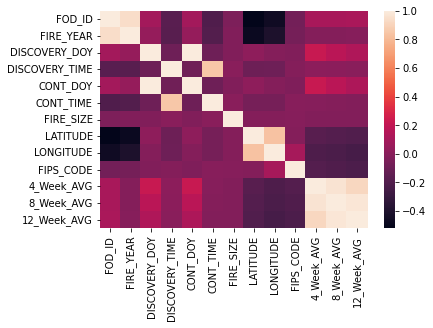

In [93]:
sns.heatmap(new_england.corr())

In [94]:
new_england.set_index('FOD_ID',inplace=True)

In [95]:
X = new_england.drop(['FPA_ID','NWCG_REPORTING_UNIT_ID','SOURCE_SYSTEM_TYPE','SOURCE_SYSTEM','CONT_DOY','CONT_TIME','CONT_DATE','NWCG_REPORTING_AGENCY',"DISCOVERY_TIME",'NWCG_CAUSE_CLASSIFICATION','NWCG_REPORTING_UNIT_NAME','SOURCE_REPORTING_UNIT','SOURCE_REPORTING_UNIT_NAME','OWNER_DESCR',"FIPS_NAME",'DISCOVERY_DATE','FIRE_SIZE','FIRE_SIZE_CLASS'],axis=1)

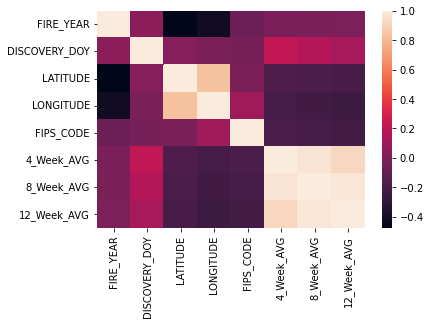

In [96]:
sns.heatmap(X.corr())

In [97]:
X_one_hot = pd.get_dummies(X,columns=['NWCG_GENERAL_CAUSE','FIPS_CODE',"STATE"])

In [98]:
y = new_england.FIRE_SIZE

In [99]:
X_train, X_test, y_train, y_test = train_test_split(X_one_hot, y, test_size=0.33, random_state=42) #stratify = True

In [100]:
y_cat = new_england.FIRE_SIZE_CLASS
X_train, X_test, y_train_cat, y_test_cat = train_test_split(X_one_hot, y_cat, test_size=0.33, random_state=42) #stratify = True

In [101]:
X_train

FIRE_YEAR  DISCOVERY_DOY   LATITUDE  LONGITUDE  4_Week_AVG  \
FOD_ID                                                                  
1464841         2009            306  45.418806 -69.017028        0.00   
300247522       2015            264  44.492190 -69.008080       88.50   
400142058       2017             68  41.844417 -72.095511      211.00   
400091217       2016            201  41.763120 -73.027518      168.25   
201832325       2013            117  44.083889 -70.401778        0.00   
...              ...            ...        ...        ...         ...   
300111050       2014            128  43.499344 -70.433027        0.00   
201834544       2013             98  44.744333 -67.423500        0.00   
201835165       2013            124  44.265528 -68.574667        0.50   
765556          2001            287  46.008889 -68.308056      166.00   
400088531       2016            136  41.696120 -73.242979       98.00   

           8_Week_AVG  12_Week_AVG  NWCG_GENERAL_CAUSE_Arson/incendiarism  \
FOD_ID                                                                      
1464841         0.000     0.000000                                      1   
300247522      89.250    89.500000                                      0   
400142058     211.000   214.250000                                      0   
400091217     133.125   121.416667                                      0   
201832325       0.000     0.000000                                      0   
...               ...          ...                                    ...   
300111050       0.000     4.833333                                      0   
201834544       0.000     0.000000                                      0   
201835165       0.250     0.166667                                      0   
765556        191.625   153.083333                                      0   
400088531      81.500    84.333333                                      0   

           NWCG_GENERAL_CAUSE_Debris and open burning  \
FOD_ID                                                  
1464841                                             0   
300247522                                           1   
400142058                                           0   
400091217                                           0   
201832325                                           0   
...                                               ...   
300111050                                           0   
201834544                                           0   
201835165                                           0   
765556                                              0   
400088531                                           0   

           NWCG_GENERAL_CAUSE_Equipment and vehicle use  ...  \
FOD_ID                                                   ...   
1464841                                               0  ...   
300247522                                             0  ...   
400142058                                             0  ...   
400091217                                             0  ...   
201832325                                             0  ...   
...                                                 ...  ...   
300111050                                             0  ...   
201834544                                             0  ...   
201835165                                             0  ...   
765556                                                0  ...   
400088531                                             0  ...   

           FIPS_CODE_50003.0  FIPS_CODE_50021.0  FIPS_CODE_50025.0  \
FOD_ID                                                               
1464841                    0                  0                  0   
300247522                  0                  0                  0   
400142058                  0                  0                  0   
400091217                  0                  0                  0   
201832325                  0                  0                 

In [102]:
def run_model(X_train,X_test,y_train,y_test,model):
  """
  Function to execute different models
  """
  model.fit(X_train,y_train);
  y_hat = model.predict(X_test)
  print('MSE : ',(mean_squared_error(y_test,y_hat)))
  print('MAE : ',(mean_absolute_error(y_test,y_hat)))
  return y_hat

In [103]:
model = RandomForestRegressor()

In [104]:
rfc_hat = run_model(X_train,X_test,y_train,y_test,model)

MSE :  247.4438172045505
MAE :  2.1641396419581045


In [105]:
model = LinearRegression()
lr_hat = run_model(X_train,X_test,y_train,y_test,model)

MSE :  168.83934378821095
MAE :  3.091846386606821


In [106]:
rfc_r2_score = r2_score(y_test, rfc_hat)
lr_r2_score = r2_score(y_test, lr_hat)
print(rfc_r2_score)
print(lr_r2_score)

-0.4670016492955955
-0.000985187674095389


###6.2 Classification
Later, we approached our second problem classification, i.e., trying to predict a specific fire class given certain conditions. We used multiple classification models to predict the fire class accurately. The fire class was divided into six categories - A to F, depending on its impact. Before making any classification, we first checked the distribution of data. It was highly imbalanced as more than 95% of rows belong to classes A and B. We used logistic regression with class = ‘balanced’ parameter to approach this problem, which provides calculated weights to every class while calculating the probability of belonging to a class. This helped us improve our ROC-AUC score. The next model we tried was Random Forest Classifier, an ensemble technique to predict the classes. We trained this model after validating multiple hyperparameters to optimize the ROC-AUC score. The last model we used was a Balanced Random Forest Classifier from the imblearn library. It makes random undersampling of the dominant class to make the model better learn about the data. Both the models worked for us getting the predictions for both fire size and fire class.

In [107]:
log = LogisticRegression(solver='liblinear',class_weight='balanced')

In [108]:
log.fit(X_train,y_train_cat)

LogisticRegression(class_weight='balanced', solver='liblinear')

In [109]:
accuracy_score(y_test_cat,log.predict(X_test))

0.5821271239773442

In [110]:
f1_score(y_test_cat.replace(['A','B','C','D','E','F'],[1,2,3,4,5,6]),pd.Series(log.predict(X_test)).replace(['A','B','C','D','E','F'],[1,2,3,4,5,6]),average='weighted')

0.5885895066326013

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


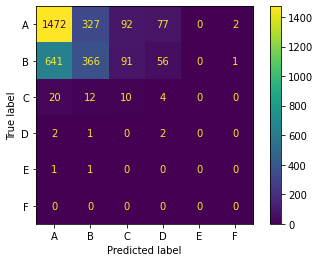

In [111]:
plot_confusion_matrix(y_true=y_test_cat,X=X_test,estimator=log)

In [112]:
rfc = RandomForestClassifier(n_estimators=50)

In [113]:
rfc.fit(X_train,y_train_cat)

RandomForestClassifier(n_estimators=50)

In [114]:
accuracy_score(y_test_cat,rfc.predict(X_test))

0.631214600377596

In [115]:
f1_score(y_test_cat.replace(['A','B','C','D','E','F'],[1,2,3,4,5,6]),pd.Series(rfc.predict(X_test)).replace(['A','B','C','D','E','F'],[1,2,3,4,5,6]),average='weighted')

0.6120704424334925

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


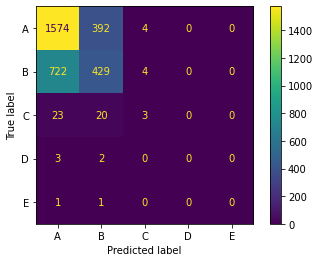

In [116]:
plot_confusion_matrix(y_true=y_test_cat,X=X_test,estimator=rfc)

In [117]:
y_train_cat.value_counts()

A    4047
B    2269
C     124
D       7
E       4
F       1
Name: FIRE_SIZE_CLASS, dtype: int64

In [118]:
brfc = BalancedRandomForestClassifier(n_estimators=400,sampling_strategy='auto')

In [119]:
brfc.fit(X_train,y_train_cat)

BalancedRandomForestClassifier(n_estimators=400)

In [120]:
accuracy_score(y_test_cat,brfc.predict(X_test))

0.14663310258023915

In [121]:
f1_score(y_test_cat.replace(['A','B','C','D','E','F'],[1,2,3,4,5,6]),pd.Series(brfc.predict(X_test)).replace(['A','B','C','D','E','F'],[1,2,3,4,5,6]),average='weighted')

0.17800807608244223

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


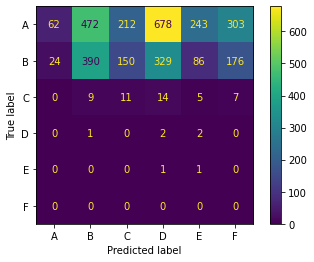

In [122]:
plot_confusion_matrix(y_true=y_test_cat,X=X_test,estimator=brfc)

##**7. Importing Census Data**

In [123]:
census_data = pd.read_csv("/content/drive/Shareddrives/Capstone_Project/census_data.csv")

In [124]:
census_data.head()

Fact  \
0         Population Estimates, July 1 2021, (V2021)   
1  Population estimates base, April 1, 2020, (V2021)   
2  Population, percent change - April 1, 2020 (es...   
3                  Population, Census, April 1, 2020   
4                  Population, Census, April 1, 2010   

  New London County, Connecticut New Haven County, Connecticut  \
0                        268,805                       863,700   
1                        268,555                       864,835   
2                           0.1%                         -0.1%   
3                        268,555                       864,835   
4                        274,055                       862,477   

  Middlesex County, Connecticut Litchfield County, Connecticut  \
0                       164,759                        185,000   
1                       164,245                        185,186   
2                          0.3%                          -0.1%   
3                       164,245                        185,186   
4                       165,676                        189,927   

  Hartford County, Connecticut Fairfield County, Connecticut  \
0                      896,854                       959,768   
1                      899,498                       957,419   
2                        -0.3%                          0.2%   
3                      899,498                       957,419   
4                      894,014                       916,829   

  Dukes County, Massachusetts Bristol County, Massachusetts  \
0                      21,097                       580,164   
1                      20,600                       579,200   
2                        2.4%                          0.2%   
3                      20,600                       579,200   
4                      16,535                       548,285   

  Berkshire County, Massachusetts  ... Chittenden County, Vermont  \
0                         128,657  ...                    168,865   
1                         129,026  ...                    168,323   
2                           -0.3%  ...                       0.3%   
3                         129,026  ...                    168,323   
4                         131,219  ...                    156,545   

  Caledonia County, Vermont Bennington County, Vermont  \
0                    30,403                     37,312   
1                    30,233                     37,347   
2                      0.6%                      -0.1%   
3                    30,233                     37,347   
4                    31,227                     37,125   

  Addison County, Vermont Providence County, Rhode Island  \
0                  37,260                         658,221   
1                  37,363                         660,741   
2                   -0.3%                           -0.4%   
3                  37,363                         660,741   
4                  36,821                         626,667   

  Windsor County, Vermont Rutland County, Vermont Orleans County, Vermont  \
0                  58,196                  60,591                  27,546   
1                  57,753                  60,572                  27,393   
2                    0.8%                       Z                    0.6%   
3                  57,753                  60,572                  27,393   
4                  56,670                  61,642                  27,231   

  Orange County, Vermont Lamoille County, Vermont  
0                 29,541                   26,126  
1                 29,277                   25,945  
2                   0.9%                     0.7%  
3                 29,277                   25,945  
4                 28,936                   24,475  

[5 rows x 60 columns]

In [125]:
census_data.shape

(83, 60)

In [126]:
census_data.set_index('Fact')

New London County, Connecticut  \
Fact                                                                                
Population Estimates, July 1 2021, (V2021)                                268,805   
Population estimates base, April 1, 2020, (V2021)                         268,555   
Population, percent change - April 1, 2020 (est...                           0.1%   
Population, Census, April 1, 2020                                         268,555   
Population, Census, April 1, 2010                                         274,055   
...                                                                           ...   
FN                                                                            NaN   
X                                                                             NaN   
S                                                                             NaN   
NaN                                                                           NaN   
Z                                                                             NaN   

                                                   New Haven County, Connecticut  \
Fact                                                                               
Population Estimates, July 1 2021, (V2021)                               863,700   
Population estimates base, April 1, 2020, (V2021)                        864,835   
Population, percent change - April 1, 2020 (est...                         -0.1%   
Population, Census, April 1, 2020                                        864,835   
Population, Census, April 1, 2010                                        862,477   
...                                                                          ...   
FN                                                                           NaN   
X                                                                            NaN   
S                                                                            NaN   
NaN                                                                          NaN   
Z                                                                            NaN   

                                                   Middlesex County, Connecticut  \
Fact                                                                               
Population Estimates, July 1 2021, (V2021)                               164,759   
Population estimates base, April 1, 2020, (V2021)                        164,245   
Population, percent change - April 1, 2020 (est...                          0.3%   
Population, Census, April 1, 2020                                        164,245   
Population, Census, April 1, 2010                                        165,676   
...                                                                          ...   
FN                                                                           NaN   
X                                                                            NaN   
S                                                                            NaN   
NaN                                                                          NaN   
Z                                                                            NaN   

                                                   Litchfield County, Connecticut  \
Fact                                                                                
Population Estimates, July 1 2021, (V2021)                                185,000   
Population estimates base, April 1, 2020, (V2021)                         185,186   
Population, percent change - April 1, 2020 (est...                          -0.1%   
Population, Census, April 1, 2020                                         185,186   
Population, Census, April 1, 2010                                         189,927   
...                                                                           ...   
FN                                                                            N

In [127]:
census_data = census_data.T

In [128]:
census_data.columns = census_data.iloc[0]
census_data.drop(census_data.index[0], inplace = True)
census_data.head()

Fact                           Population Estimates, July 1 2021, (V2021)  \
New London County, Connecticut                                    268,805   
New Haven County, Connecticut                                     863,700   
Middlesex County, Connecticut                                     164,759   
Litchfield County, Connecticut                                    185,000   
Hartford County, Connecticut                                      896,854   

Fact                           Population estimates base, April 1, 2020, (V2021)  \
New London County, Connecticut                                           268,555   
New Haven County, Connecticut                                            864,835   
Middlesex County, Connecticut                                            164,245   
Litchfield County, Connecticut                                           185,186   
Hartford County, Connecticut                                             899,498   

Fact                           Population, percent change - April 1, 2020 (estimates base) to July 1, 2021, (V2021)  \
New London County, Connecticut                                               0.1%                                     
New Haven County, Connecticut                                               -0.1%                                     
Middlesex County, Connecticut                                                0.3%                                     
Litchfield County, Connecticut                                              -0.1%                                     
Hartford County, Connecticut                                                -0.3%                                     

Fact                           Population, Census, April 1, 2020  \
New London County, Connecticut                           268,555   
New Haven County, Connecticut                            864,835   
Middlesex County, Connecticut                            164,245   
Litchfield County, Connecticut                           185,186   
Hartford County, Connecticut                             899,498   

Fact                           Population, Census, April 1, 2010  \
New London County, Connecticut                           274,055   
New Haven County, Connecticut                            862,477   
Middlesex County, Connecticut                            165,676   
Litchfield County, Connecticut                           189,927   
Hartford County, Connecticut                             894,014   

Fact                           Persons under 5 years, percent  \
New London County, Connecticut                           4.9%   
New Haven County, Connecticut                            5.1%   
Middlesex County, Connecticut                            4.1%   
Litchfield County, Connecticut                           4.1%   
Hartford County, Connecticut                             5.4%   

Fact                           Persons under 18 years, percent  \
New London County, Connecticut                           19.2%   
New Haven County, Connecticut                            20.0%   
Middlesex County, Connecticut                            17.3%   
Litchfield County, Connecticut                           18.0%   
Hartford County, Connecticut                             20.9%   

Fact                           Persons 65 years and over, percent  \
New London County, Connecticut                              18.8%   
New Haven County, Connecticut                               17.9%   
Middlesex County, Connecticut                               21.0%   
Litchfield County, Connecticut                              22.0%   
Hartford County, Connecticut                                17.4%   

Fact                           Female persons, percent White alone, percent  \
New London County, Connecticut                   49.8%                83.6%   
New Haven County, Connecticut                    51.8%                77.3%   
Middlesex County, Connecticut                    51.3%     

In [129]:
census_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 59 entries, New London County, Connecticut to Lamoille County, Vermont
Data columns (total 83 columns):
 #   Column                                                                                  Non-Null Count  Dtype 
---  ------                                                                                  --------------  ----- 
 0   Population Estimates, July 1 2021, (V2021)                                              59 non-null     object
 1   Population estimates base, April 1, 2020, (V2021)                                       59 non-null     object
 2   Population, percent change - April 1, 2020 (estimates base) to July 1, 2021, (V2021)    59 non-null     object
 3   Population, Census, April 1, 2020                                                       59 non-null     object
 4   Population, Census, April 1, 2010                                                       59 non-null     object
 5   Persons under 5 years, percent    

In [130]:
census_data = census_data.iloc[: , :-21]

In [131]:
census_data.reset_index(inplace = True)
census_data.rename(columns = {'index':'County'}, inplace = True)
census_data.head()

Fact                          County  \
0     New London County, Connecticut   
1      New Haven County, Connecticut   
2      Middlesex County, Connecticut   
3     Litchfield County, Connecticut   
4       Hartford County, Connecticut   

Fact Population Estimates, July 1 2021, (V2021)  \
0                                       268,805   
1                                       863,700   
2                                       164,759   
3                                       185,000   
4                                       896,854   

Fact Population estimates base, April 1, 2020, (V2021)  \
0                                              268,555   
1                                              864,835   
2                                              164,245   
3                                              185,186   
4                                              899,498   

Fact Population, percent change - April 1, 2020 (estimates base) to July 1, 2021, (V2021)  \
0                                                  0.1%                                     
1                                                 -0.1%                                     
2                                                  0.3%                                     
3                                                 -0.1%                                     
4                                                 -0.3%                                     

Fact Population, Census, April 1, 2020 Population, Census, April 1, 2010  \
0                              268,555                           274,055   
1                              864,835                           862,477   
2                              164,245                           165,676   
3                              185,186                           189,927   
4                              899,498                           894,014   

Fact Persons under 5 years, percent Persons under 18 years, percent  \
0                              4.9%                           19.2%   
1                              5.1%                           20.0%   
2                              4.1%                           17.3%   
3                              4.1%                           18.0%   
4                              5.4%                           20.9%   

Fact Persons 65 years and over, percent Female persons, percent  ...  \
0                                 18.8%                   49.8%  ...   
1                                 17.9%                   51.8%  ...   
2                                 21.0%                   51.3%  ...   
3                                 22.0%                   50.5%  ...   
4                                 17.4%                   51.4%  ...   

Fact All firms, 2012 Men-owned firms, 2012 Women-owned firms, 2012  \
0             20,244                11,621                   6,428   
1             73,035                42,046                  23,620   
2             17,309                10,011                   5,354   
3             20,187                12,048                   6,092   
4             73,386                41,848                  24,353   

Fact Minority-owned firms, 2012 Nonminority-owned firms, 2012  \
0                         2,519                        16,823   
1                        13,508                        56,676   
2                         1,134                        15,462   
3                         1,330                        18,350   
4                        14,844                        55,488   

Fact Veteran-owned firms, 2012 Nonveteran-owned firms, 2012  \
0                        2,358                       16,712   
1                        7,336                       62,207   
2                        2,071                       14,440   
3                        1,755                       17,666   
4                        7,061                       62,045   

Fact Population per square mile, 201

###7.1 Exploratory Data Analysis

####7.1.1 Census Dataset

To begin with, we preprocessed the data so it was the right type and was ready for analysis. The picture posted below illustrates certain values in the data. We chose to simply convert data values with letters to NaN as they signify a lack of data/lack of disclosure. 

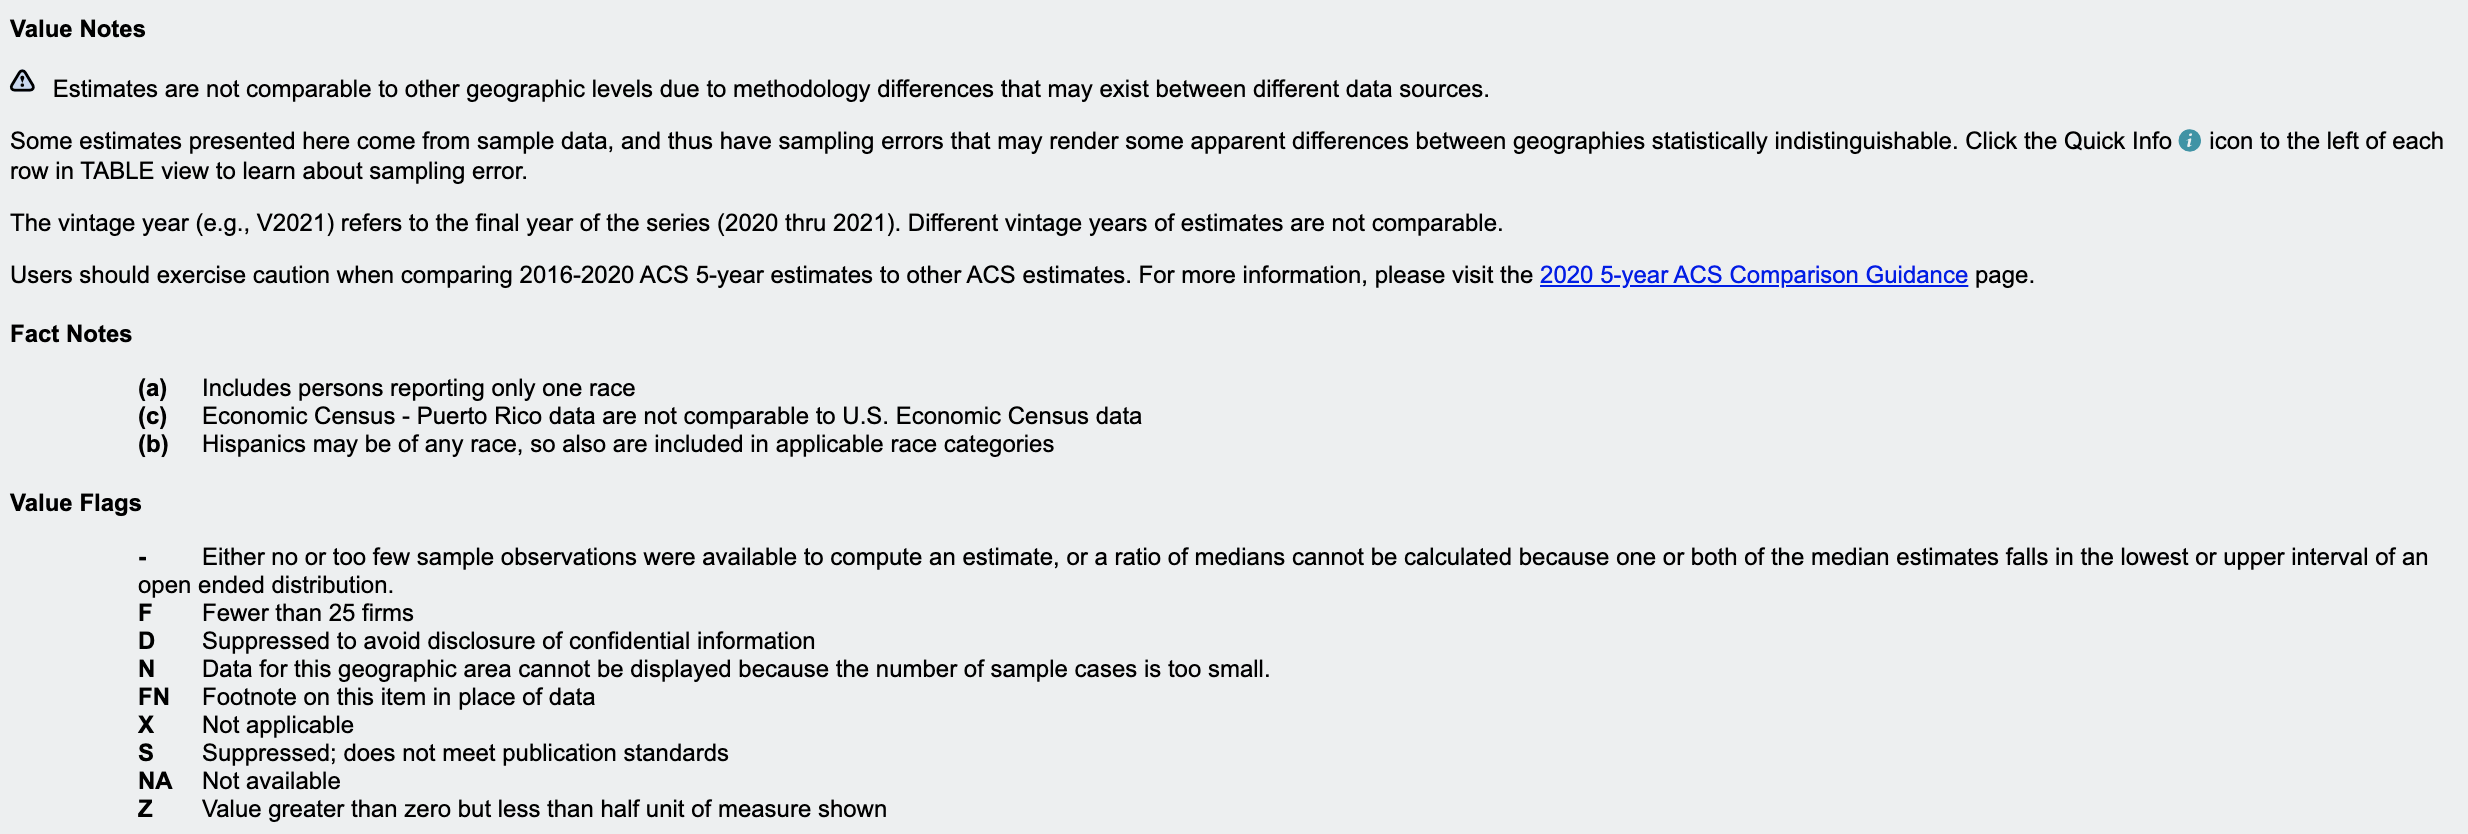

In [132]:
cols = census_data.columns[1:]
census_data[cols] = census_data[cols].apply(lambda x: x.str.replace(',', '').str.replace('$', '').str.replace('%', '').str.replace('"', '').str.replace(r'[a-zA-Z]+',""), axis=1)
census_data[cols] = census_data[cols].apply(pd.to_numeric, axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


In [133]:
census_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59 entries, 0 to 58
Data columns (total 63 columns):
 #   Column                                                                                  Non-Null Count  Dtype  
---  ------                                                                                  --------------  -----  
 0   County                                                                                  59 non-null     object 
 1   Population Estimates, July 1 2021, (V2021)                                              59 non-null     float64
 2   Population estimates base, April 1, 2020, (V2021)                                       59 non-null     float64
 3   Population, percent change - April 1, 2020 (estimates base) to July 1, 2021, (V2021)    58 non-null     float64
 4   Population, Census, April 1, 2020                                                       59 non-null     float64
 5   Population, Census, April 1, 2010                                        

Subsequently, we continued to analyze median household income and household income per capita according to counties. This was followed by finding the counties with the lowest and highest of the above-mentioned values in order to observe certain attributes that may be unique to those counties. 

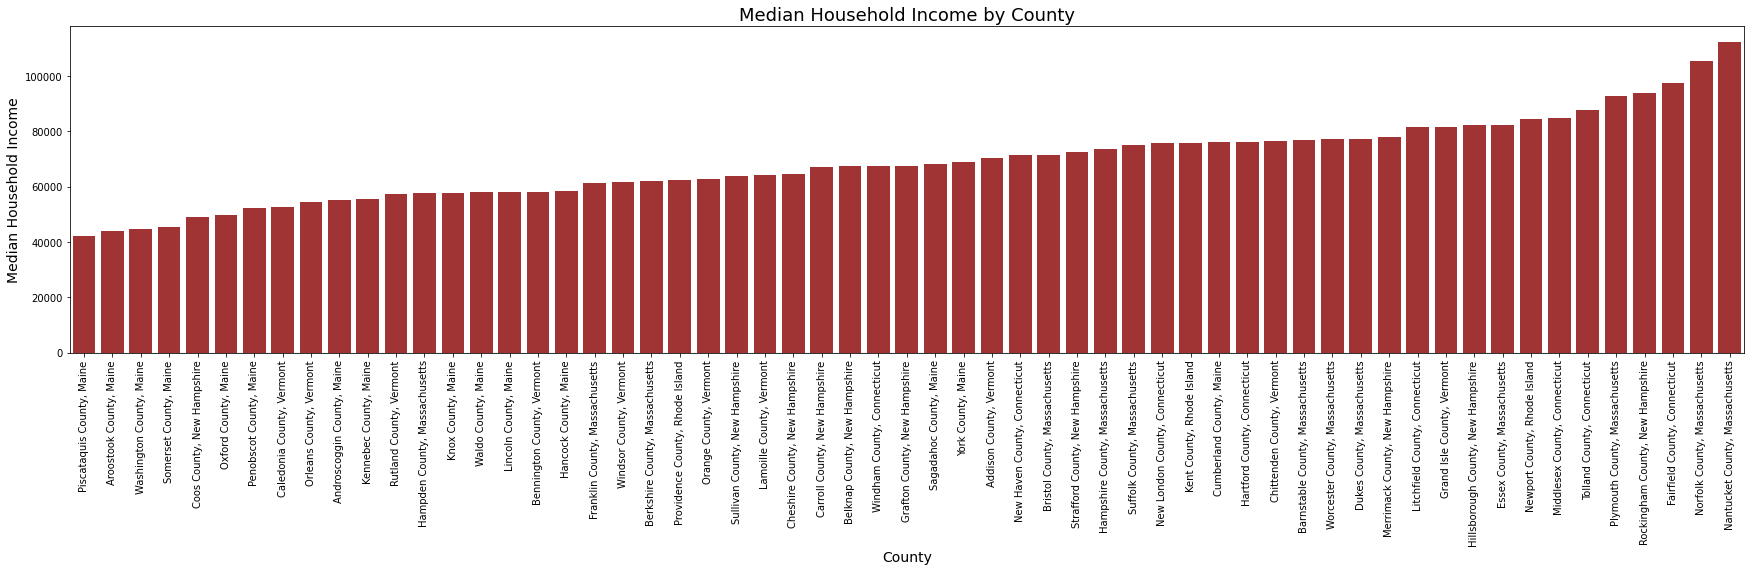

In [134]:
plt.figure(figsize=(30, 6))
sns.barplot(x = 'County',
            y = 'Median household income (in 2020 dollars), 2016-2020',
            data = census_data,
            color='firebrick', 
            order=census_data.sort_values('Median household income (in 2020 dollars), 2016-2020').County)
plt.title('Median Household Income by County', size = 18)
plt.xlabel('County', size = 14)
plt.ylabel('Median Household Income', size = 14)
plt.xticks(rotation=90)
plt.show()

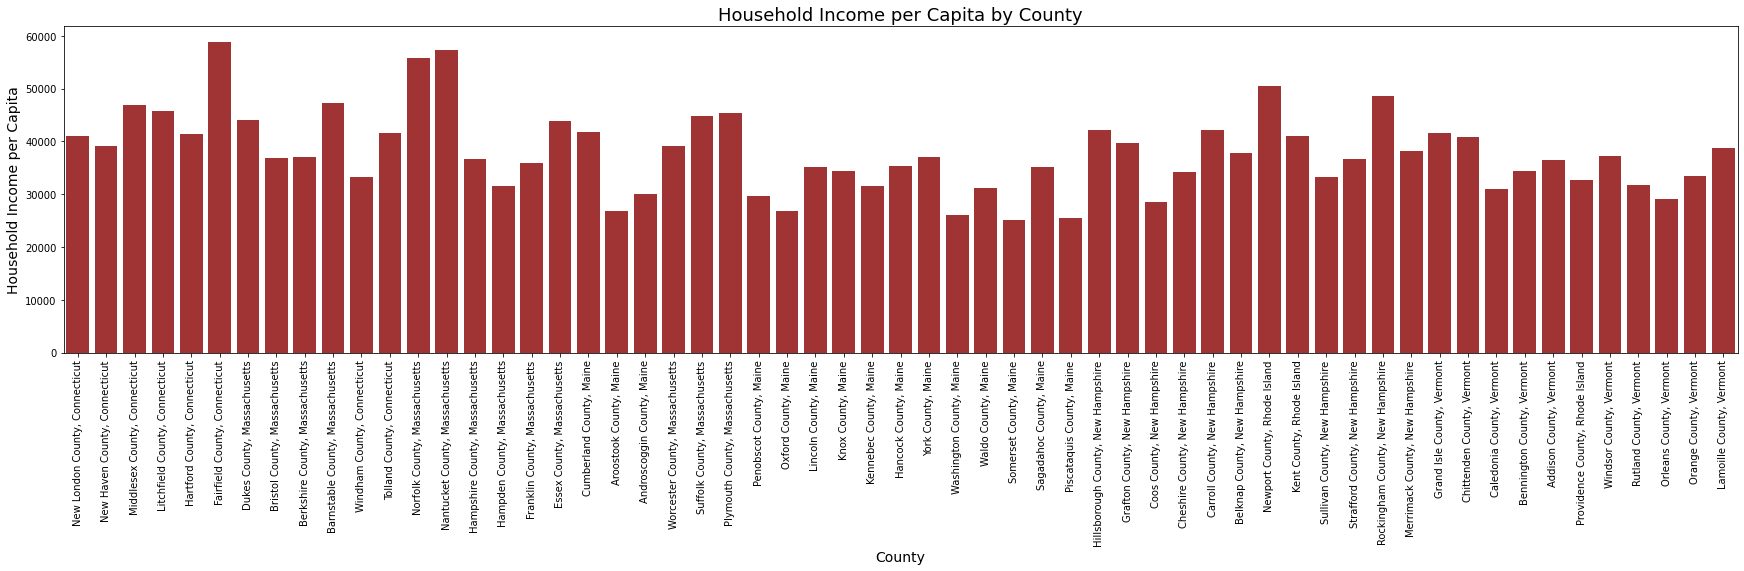

In [135]:
plt.figure(figsize=(30, 6))
sns.barplot(x = 'County',
            y = 'Per capita income in past 12 months (in 2020 dollars), 2016-2020',
            data = census_data,
            color='firebrick')
plt.title('Household Income per Capita by County', size = 18)
plt.xlabel('County', size = 14)
plt.ylabel('Household Income per Capita', size = 14)
plt.xticks(rotation=90)
plt.show()

In [136]:
cols = ['County', 'Households, 2016-2020', 'Persons in poverty, percent','White alone, not Hispanic or Latino, percent','Black or African American alone, percent','American Indian and Alaska Native alone, percent','Asian alone, percent','Native Hawaiian and Other Pacific Islander alone, percent','Two or More Races, percent','Hispanic or Latino, percent']

In [137]:
census_data.loc[census_data['Per capita income in past 12 months (in 2020 dollars), 2016-2020'] == census_data['Per capita income in past 12 months (in 2020 dollars), 2016-2020'].max()][cols]

Fact                         County  Households, 2016-2020  \
5     Fairfield County, Connecticut               345070.0   

Fact  Persons in poverty, percent  \
5                             8.8   

Fact  White alone, not Hispanic or Latino, percent  \
5                                             60.9   

Fact  Black or African American alone, percent  \
5                                         12.9   

Fact  American Indian and Alaska Native alone, percent  Asian alone, percent  \
5                                                  0.5                   5.9   

Fact  Native Hawaiian and Other Pacific Islander alone, percent  \
5                                                   0.1           

Fact  Two or More Races, percent  Hispanic or Latino, percent  
5                            2.2                         20.5

In [138]:
census_data.loc[census_data['Per capita income in past 12 months (in 2020 dollars), 2016-2020'] == census_data['Per capita income in past 12 months (in 2020 dollars), 2016-2020'].min()][cols]

Fact                  County  Households, 2016-2020  \
33    Somerset County, Maine                21645.0   

Fact  Persons in poverty, percent  \
33                           14.5   

Fact  White alone, not Hispanic or Latino, percent  \
33                                            95.4   

Fact  Black or African American alone, percent  \
33                                         0.6   

Fact  American Indian and Alaska Native alone, percent  Asian alone, percent  \
33                                                 0.6                   0.7   

Fact  Native Hawaiian and Other Pacific Islander alone, percent  \
33                                                  NaN           

Fact  Two or More Races, percent  Hispanic or Latino, percent  
33                           1.6                          1.2

In [139]:
census_data.loc[census_data['Median household income (in 2020 dollars), 2016-2020'] == census_data['Median household income (in 2020 dollars), 2016-2020'].max()][cols]

Fact                           County  Households, 2016-2020  \
13    Nantucket County, Massachusetts                 3709.0   

Fact  Persons in poverty, percent  \
13                            5.3   

Fact  White alone, not Hispanic or Latino, percent  \
13                                            71.1   

Fact  Black or African American alone, percent  \
13                                        11.3   

Fact  American Indian and Alaska Native alone, percent  Asian alone, percent  \
13                                                 0.4                   2.0   

Fact  Native Hawaiian and Other Pacific Islander alone, percent  \
13                                                  0.1           

Fact  Two or More Races, percent  Hispanic or Latino, percent  
13                           1.9                         15.2

In [140]:
census_data.loc[census_data['Median household income (in 2020 dollars), 2016-2020'] == census_data['Median household income (in 2020 dollars), 2016-2020'].min()][cols]

Fact                     County  Households, 2016-2020  \
35    Piscataquis County, Maine                 7180.0   

Fact  Persons in poverty, percent  \
35                           14.6   

Fact  White alone, not Hispanic or Latino, percent  \
35                                            94.7   

Fact  Black or African American alone, percent  \
35                                         0.6   

Fact  American Indian and Alaska Native alone, percent  Asian alone, percent  \
35                                                 0.7                   1.1   

Fact  Native Hawaiian and Other Pacific Islander alone, percent  \
35                                                  NaN           

Fact  Two or More Races, percent  Hispanic or Latino, percent  
35                           1.7                          1.5

We can see from above that Nantucket County and Fairfield County have the highest median income and income per capita respectively. Furthermore, we can see that Somerset County and Piscataquis County have the lowest income per capita and median income. Next, we decided to illustrate a correlation matrix to identify certain variables we wanted to further explore. We decided to further explore poverty rates, household numbers, population, and county according to race percentages. 

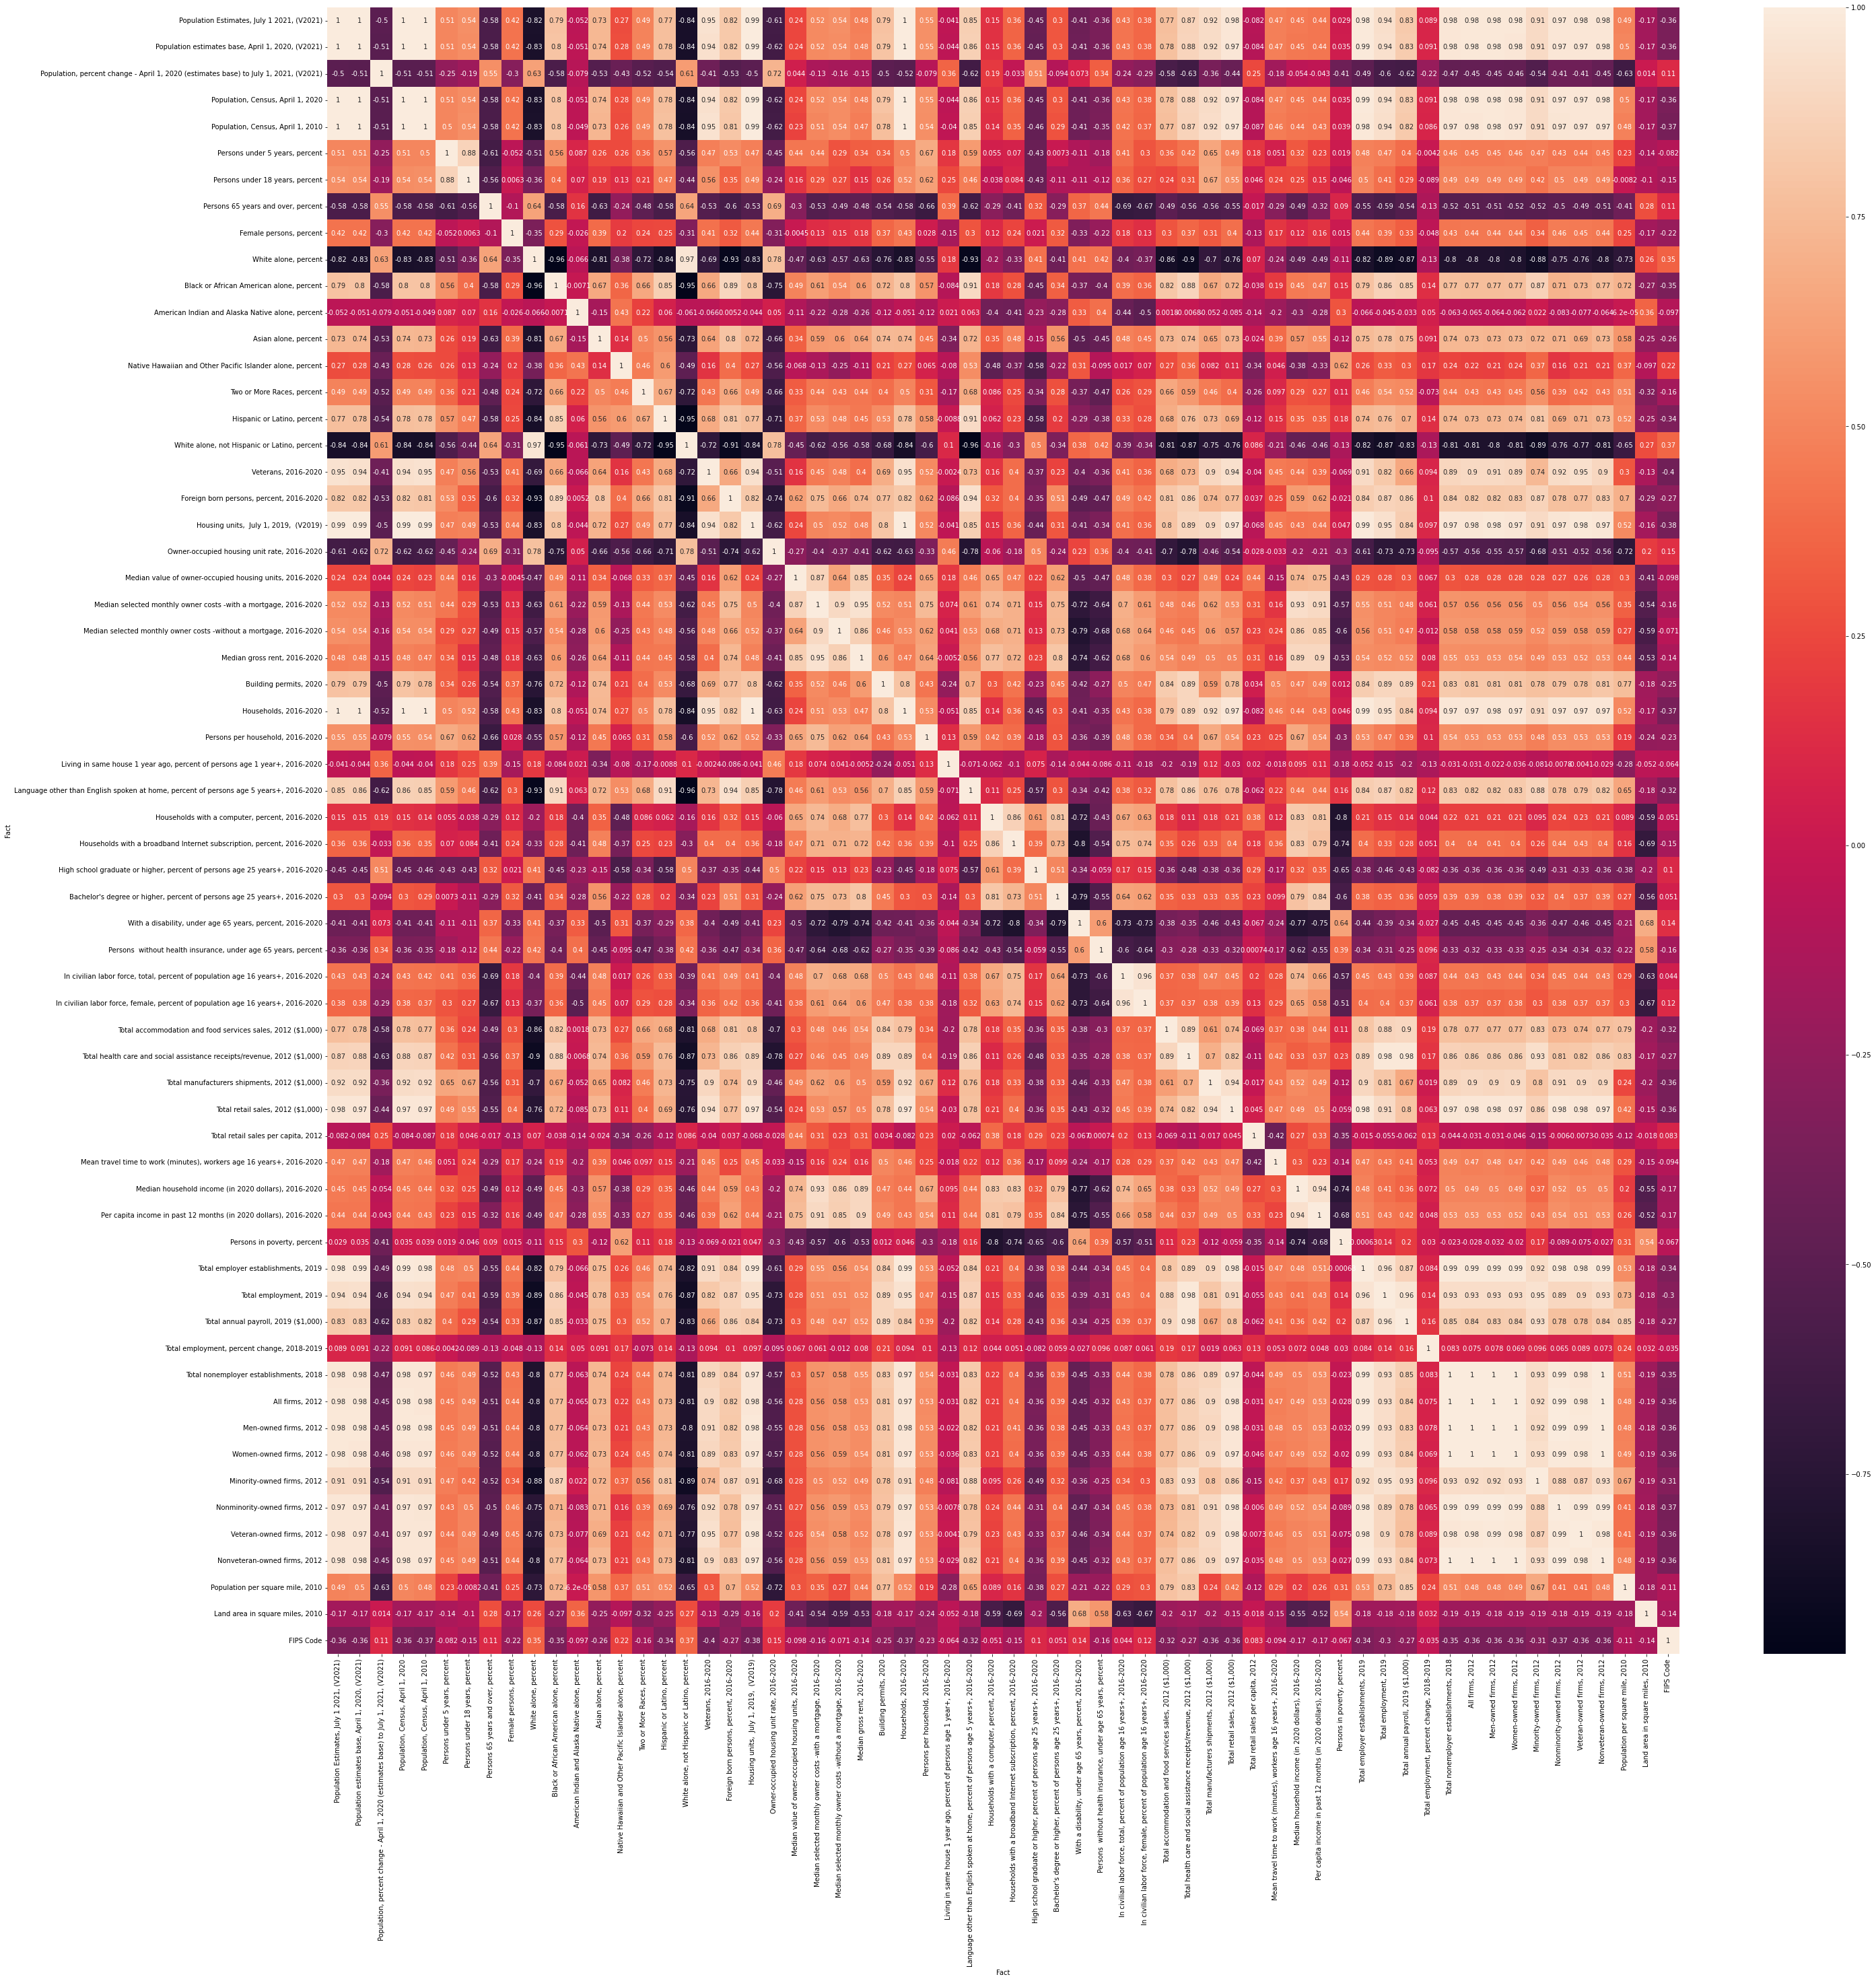

In [141]:
corrMatrix = census_data.corr()
plt.figure(figsize=(45, 45))
sns.heatmap(corrMatrix, annot=True)
plt.show()

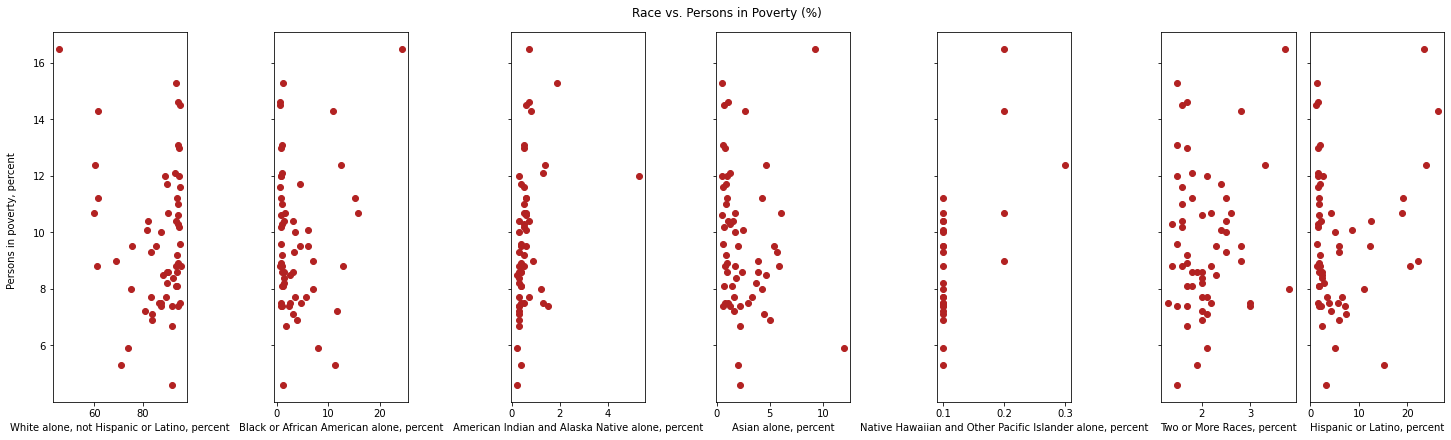

In [142]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots(1, 7, constrained_layout = True, figsize=(20,6), sharey = True)
fig.suptitle('Race vs. Persons in Poverty (%)')
fig.text(0, 0.5, 'Persons in poverty, percent', va='center', rotation='vertical')
ax1.scatter(data=census_data, x='White alone, not Hispanic or Latino, percent', y="Persons in poverty, percent", color='firebrick')
ax1.set(xlabel="White alone, not Hispanic or Latino, percent")
ax2.scatter(data=census_data, x='Black or African American alone, percent', y="Persons in poverty, percent", color='firebrick')
ax2.set(xlabel="Black or African American alone, percent")
ax3.scatter(data=census_data, x='American Indian and Alaska Native alone, percent', y="Persons in poverty, percent", color='firebrick')
ax3.set(xlabel="American Indian and Alaska Native alone, percent")
ax4.scatter(data=census_data, x='Asian alone, percent', y="Persons in poverty, percent", color='firebrick')
ax4.set(xlabel="Asian alone, percent")
ax5.scatter(data=census_data, x='Native Hawaiian and Other Pacific Islander alone, percent', y="Persons in poverty, percent", color='firebrick')
ax5.set(xlabel="Native Hawaiian and Other Pacific Islander alone, percent")
ax6.scatter(data=census_data, x='Two or More Races, percent', y="Persons in poverty, percent", color='firebrick')
ax6.set(xlabel="Two or More Races, percent")
ax7.scatter(data=census_data, x='Hispanic or Latino, percent', y="Persons in poverty, percent", color='firebrick')
ax7.set(xlabel="Hispanic or Latino, percent")
plt.show()

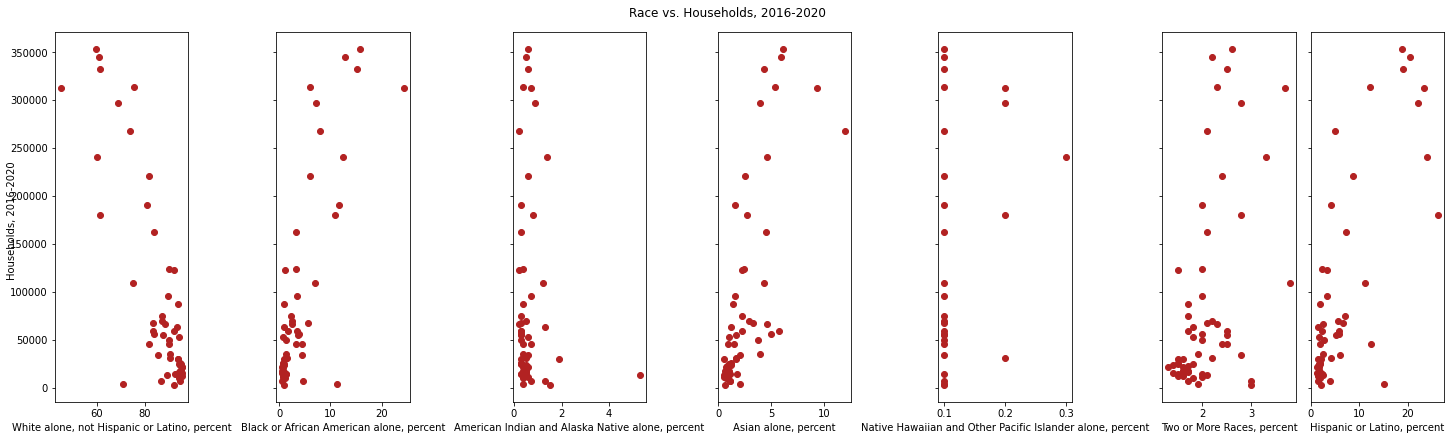

In [143]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots(1, 7, constrained_layout = True, figsize=(20,6), sharey = True)
fig.suptitle('Race vs. Households, 2016-2020')
fig.text(0, 0.5, 'Households, 2016-2020', va='center', rotation='vertical')
ax1.scatter(data=census_data, x='White alone, not Hispanic or Latino, percent', y="Households, 2016-2020", color='firebrick')
ax1.set(xlabel="White alone, not Hispanic or Latino, percent")
ax2.scatter(data=census_data, x='Black or African American alone, percent', y="Households, 2016-2020", color='firebrick')
ax2.set(xlabel="Black or African American alone, percent")
ax3.scatter(data=census_data, x='American Indian and Alaska Native alone, percent', y="Households, 2016-2020", color='firebrick')
ax3.set(xlabel="American Indian and Alaska Native alone, percent")
ax4.scatter(data=census_data, x='Asian alone, percent', y="Households, 2016-2020", color='firebrick')
ax4.set(xlabel="Asian alone, percent")
ax5.scatter(data=census_data, x='Native Hawaiian and Other Pacific Islander alone, percent', y="Households, 2016-2020", color='firebrick')
ax5.set(xlabel="Native Hawaiian and Other Pacific Islander alone, percent")
ax6.scatter(data=census_data, x='Two or More Races, percent', y="Households, 2016-2020", color='firebrick')
ax6.set(xlabel="Two or More Races, percent")
ax7.scatter(data=census_data, x='Hispanic or Latino, percent', y="Households, 2016-2020", color='firebrick')
ax7.set(xlabel="Hispanic or Latino, percent")
plt.show()

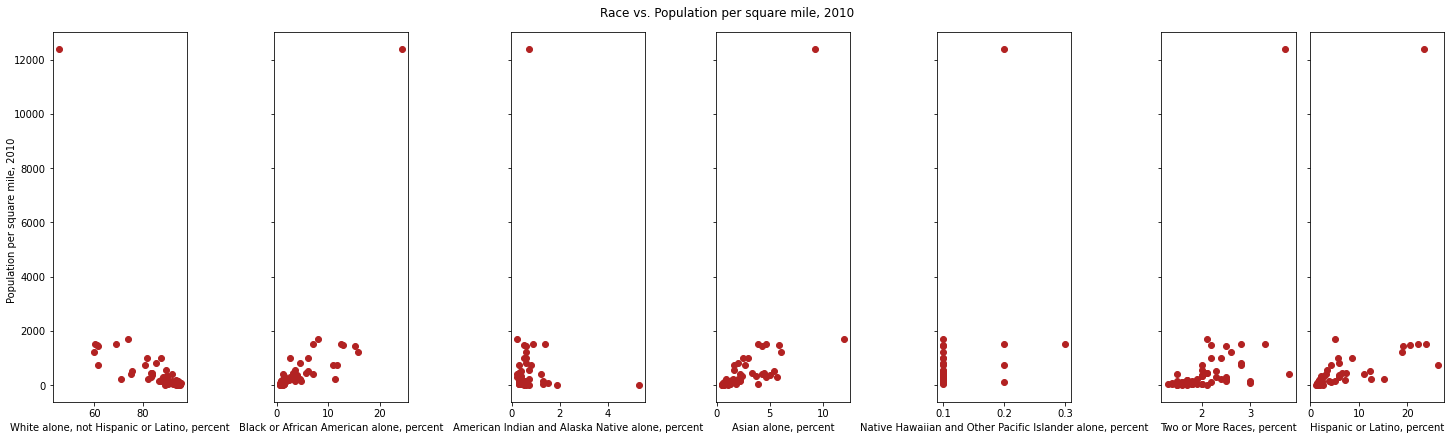

In [144]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots(1, 7, constrained_layout = True, figsize=(20,6), sharey = True)
fig.suptitle('Race vs. Population per square mile, 2010')
fig.text(0, 0.5, 'Population per square mile, 2010', va='center', rotation='vertical')
ax1.scatter(data=census_data, x='White alone, not Hispanic or Latino, percent', y="Population per square mile, 2010", color='firebrick')
ax1.set(xlabel="White alone, not Hispanic or Latino, percent")
ax2.scatter(data=census_data, x='Black or African American alone, percent', y="Population per square mile, 2010", color='firebrick')
ax2.set(xlabel="Black or African American alone, percent")
ax3.scatter(data=census_data, x='American Indian and Alaska Native alone, percent', y="Population per square mile, 2010", color='firebrick')
ax3.set(xlabel="American Indian and Alaska Native alone, percent")
ax4.scatter(data=census_data, x='Asian alone, percent', y="Population per square mile, 2010", color='firebrick')
ax4.set(xlabel="Asian alone, percent")
ax5.scatter(data=census_data, x='Native Hawaiian and Other Pacific Islander alone, percent', y="Population per square mile, 2010", color='firebrick')
ax5.set(xlabel="Native Hawaiian and Other Pacific Islander alone, percent")
ax6.scatter(data=census_data, x='Two or More Races, percent', y="Population per square mile, 2010", color='firebrick')
ax6.set(xlabel="Two or More Races, percent")
ax7.scatter(data=census_data, x='Hispanic or Latino, percent', y="Population per square mile, 2010", color='firebrick')
ax7.set(xlabel="Hispanic or Latino, percent")
plt.show()

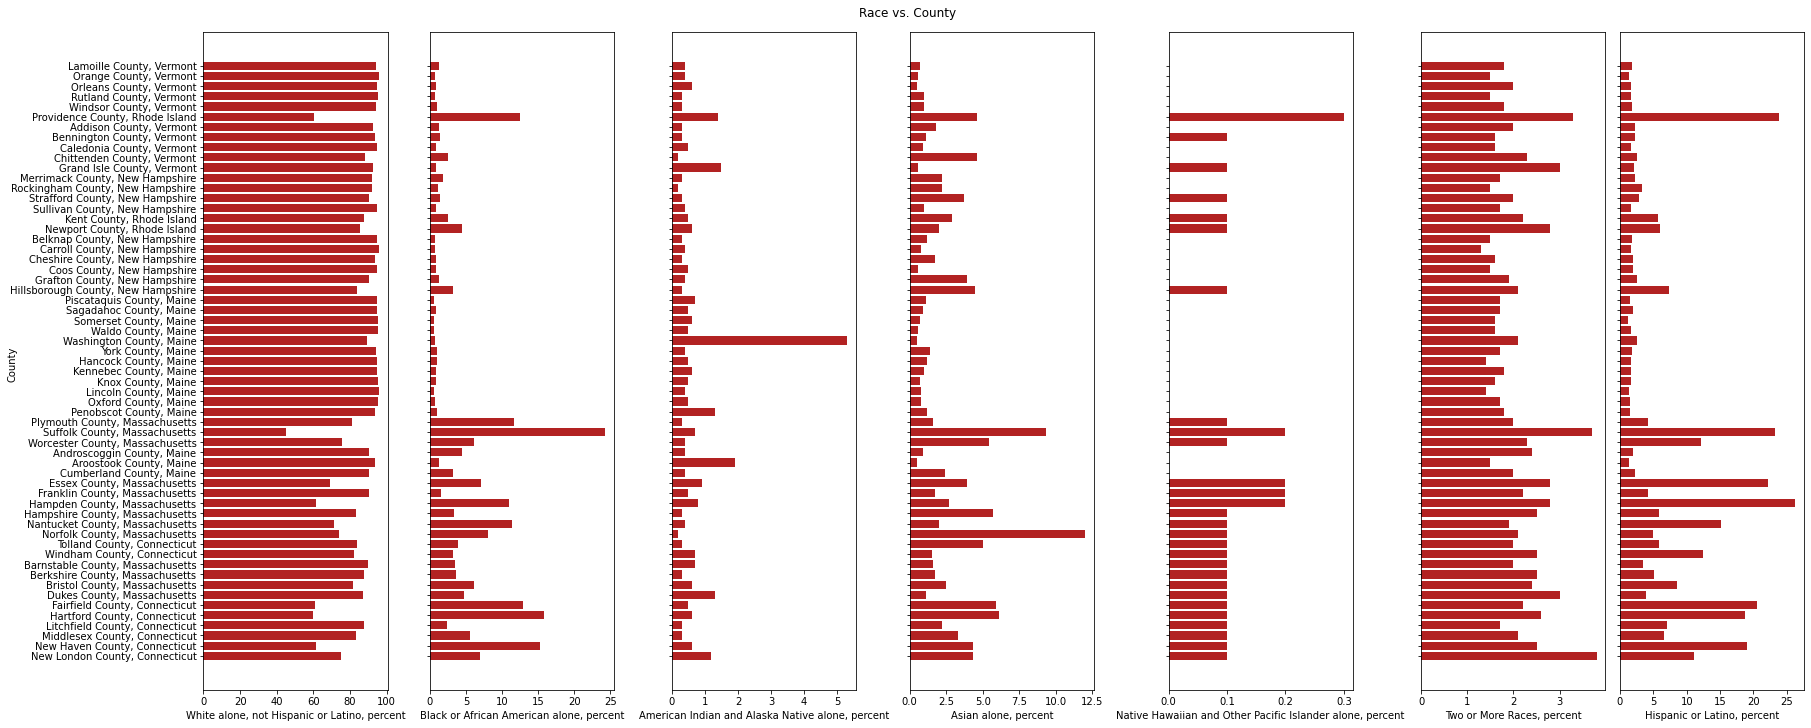

In [145]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots(1, 7, constrained_layout = True, figsize=(25,10), sharey = True)
fig.suptitle('Race vs. County')
fig.text(0, 0.5, 'County', va='center', rotation='vertical')
ax1.barh(data=census_data, width='White alone, not Hispanic or Latino, percent', y="County", color='firebrick')
ax1.set(xlabel="White alone, not Hispanic or Latino, percent")
ax2.barh(data=census_data, width='Black or African American alone, percent', y="County", color='firebrick')
ax2.set(xlabel="Black or African American alone, percent")
ax3.barh(data=census_data, width='American Indian and Alaska Native alone, percent', y="County", color='firebrick')
ax3.set(xlabel="American Indian and Alaska Native alone, percent")
ax4.barh(data=census_data, width='Asian alone, percent', y="County", color='firebrick')
ax4.set(xlabel="Asian alone, percent")
ax5.barh(data=census_data, width='Native Hawaiian and Other Pacific Islander alone, percent', y="County", color='firebrick')
ax5.set(xlabel="Native Hawaiian and Other Pacific Islander alone, percent")
ax6.barh(data=census_data, width='Two or More Races, percent', y="County", color='firebrick')
ax6.set(xlabel="Two or More Races, percent")
ax7.barh(data=census_data, width='Hispanic or Latino, percent', y="County", color='firebrick')
ax7.set(xlabel="Hispanic or Latino, percent")
plt.show()

From the above graphs, we can see that there is a slight relationship between the aforementioned variables and the percentage of races in each county. Firstly, we can see that in general the higher percentage of whites present in a county the lower the population and therefore also the lower the number of households. This relationship is inverted for the other races which illustrates that as the percentage of the specific race increases in the counties so does the population and the number of households. From the last graphs, we can also observe that counties in New England are predominantly lived in by white people. However, we also see some spikes in the other graphs. For example, we can see that Suffolk County has higher percentages of Black or African Americans, Hispanic or Latinos, and Asians. We can also see that American Indian and Alaskan Natives predominantly reside in Washington County, whereas Native Hawaiian and Other Pacific Islanders as well as Hispanic or Latinos predominantly reside in Providence County.

There are many methods that can be used to calculate wildfire costs that depend on one's taken perspective. We want to emphasize the difference in proportion wildfire costs makes up in terms of household income in different counties; therefore, we will be focusing on how much households need to pay out of pocket after a wildfire has occurred. After research, we decided to take into account the deductible that is part of the insurance plan and the increase in insurance premium after a fire claim has been submitted as a function of the value of the housing unit. This cost is an estimate of what may need to be paid out of pocket by a household that experiences a wildfire. The deductible is paid by default if the cost is larger and we decided to also add the increase in premium as the increase in yearly premium is a direct effect of the wildfire. In this case, we are only taking into account the following year's increase in insurance premiums that needs to be paid. We are using the household value as a basis for calculating the insurance premium as one should select household insurance where the dwelling is approximately the household value.

The following sources were used to find the associated values:

https://www.insurance.com/home-and-renters-insurance/home-insurance-basics/homeowners-insurance-deductibles-choose-right-one.html
https://www.insurance.com/home-and-renters-insurance/home-insurance-basics/average-homeowners-insurance-rates-by-state
https://www.fixr.com/costs/fire-damage-recovery

### 7.2 Cost Calculation

In [146]:
avg_rate = [1806, 2285, 2694, 3046, 3304]
dwelling = [200000, 300000, 400000, 500000, 600000]
deductible = [1000, 1000, 1000, 1000, 1000]
wildfire_cost = pd.DataFrame({'avg_rate':avg_rate, 'dwelling':dwelling, 'deductible':deductible})
wildfire_cost.head()

avg_rate  dwelling  deductible
0      1806    200000        1000
1      2285    300000        1000
2      2694    400000        1000
3      3046    500000        1000
4      3304    600000        1000

In [147]:
insurance_inc_first = 0.20
insurance_inc_second = 0.44
cost = []
proportion = []

for i in range(len(census_data['Median value of owner-occupied housing units, 2016-2020'])):
  avg_rate, deductible = wildfire_cost.iloc[wildfire_cost['dwelling'].sub(census_data['Median value of owner-occupied housing units, 2016-2020'][i]).abs().idxmin()][['avg_rate', 'deductible']]
  tot_cost = ((insurance_inc_first)*avg_rate) + deductible
  cost.append(tot_cost)
  prop = census_data['Median household income (in 2020 dollars), 2016-2020'][i]/tot_cost
  proportion.append(prop)


In [148]:
census_data['proportion'] = proportion
census_data['cost'] = cost

In [149]:
print(census_data['County'][census_data.index[census_data['proportion']==max(census_data['proportion'])]])
print(max(proportion))
print(census_data['County'][census_data.index[census_data['proportion']==min(census_data['proportion'])]])
print(min(proportion))

13    Nantucket County, Massachusetts
Name: County, dtype: object
67.62162813102118
35    Piscataquis County, Maine
Name: County, dtype: object
30.916103438142812


In [150]:
census_data.iloc[census_data.index[census_data['proportion']==max(census_data['proportion'])]][cols]

Fact                           County  Households, 2016-2020  \
13    Nantucket County, Massachusetts                 3709.0   

Fact  Persons in poverty, percent  \
13                            5.3   

Fact  White alone, not Hispanic or Latino, percent  \
13                                            71.1   

Fact  Black or African American alone, percent  \
13                                        11.3   

Fact  American Indian and Alaska Native alone, percent  Asian alone, percent  \
13                                                 0.4                   2.0   

Fact  Native Hawaiian and Other Pacific Islander alone, percent  \
13                                                  0.1           

Fact  Two or More Races, percent  Hispanic or Latino, percent  
13                           1.9                         15.2

In [151]:
census_data.iloc[census_data.index[census_data['proportion']==min(census_data['proportion'])]][cols]

Fact                     County  Households, 2016-2020  \
35    Piscataquis County, Maine                 7180.0   

Fact  Persons in poverty, percent  \
35                           14.6   

Fact  White alone, not Hispanic or Latino, percent  \
35                                            94.7   

Fact  Black or African American alone, percent  \
35                                         0.6   

Fact  American Indian and Alaska Native alone, percent  Asian alone, percent  \
35                                                 0.7                   1.1   

Fact  Native Hawaiian and Other Pacific Islander alone, percent  \
35                                                  NaN           

Fact  Two or More Races, percent  Hispanic or Latino, percent  
35                           1.7                          1.5

In [152]:
# For estimation purposes we have also defined a function 
def wildfire_cost_calculation(prev_fire_claims, deductible, insurance_premium, income):
  if prev_fire_claims == 0:
    tot_cost = (0*insurance_premium) + deductible
    prop = income/tot_cost
    return tot_cost, prop
  if prev_fire_claims == 1:
    tot_cost = (0.2*insurance_premium) + deductible
    prop = income/tot_cost
    return tot_cost, prop
  if prev_fire_claims >= 2:
    tot_cost = (0.44*insurance_premium) + deductible
    prop = income/tot_cost
    return tot_cost, prop

### 7.3 County Risk Analysis

In [153]:
census_data.sort_values("proportion")[-10:][['County', 'proportion']]

Fact                              County  proportion
48            Grand Isle County, Vermont   56.051476
36    Hillsborough County, New Hampshire   56.347975
47       Merrimack County, New Hampshire   57.256098
2          Middlesex County, Connecticut   58.275223
11           Tolland County, Connecticut   60.266987
23        Plymouth County, Massachusetts   60.375617
5          Fairfield County, Connecticut   63.386405
46      Rockingham County, New Hampshire   64.490048
12         Norfolk County, Massachusetts   65.448670
13       Nantucket County, Massachusetts   67.621628

In [154]:
avg_DSCI = drought[['County','DSCI', 'State']].groupby('County').mean()
avg_DSCI.sort_values("DSCI")[-10:]

DSCI
County                      
Sagadahoc County   43.522031
Strafford County   43.594828
New London County  43.819923
Fairfield County   44.110153
Litchfield County  44.143678
Rockingham County  44.314176
Tolland County     45.366858
Middlesex County   45.536877
Hartford County    46.591954
New Haven County   47.054598

In [155]:
new_england.FIPS_NAME.value_counts()[:10]

Penobscot County      1011
Aroostook County       840
Washington County      785
York County            585
Kennebec County        567
Somerset County        509
Oxford County          503
Hancock County         498
Cumberland County      424
Piscataquis County     409
Name: FIPS_NAME, dtype: int64

In [156]:
census_data.sort_values("Persons in poverty, percent")[-10:][cols]

Fact                           County  Households, 2016-2020  \
55            Rutland County, Vermont                25349.0   
24            Penobscot County, Maine                63073.0   
53    Providence County, Rhode Island               240886.0   
25               Oxford County, Maine                22359.0   
38         Coos County, New Hampshire                13967.0   
15      Hampden County, Massachusetts               180492.0   
33             Somerset County, Maine                21645.0   
35          Piscataquis County, Maine                 7180.0   
19            Aroostook County, Maine                29594.0   
22      Suffolk County, Massachusetts               312978.0   

Fact  Persons in poverty, percent  \
55                           12.0   
24                           12.1   
53                           12.4   
25                           13.0   
38                           13.1   
15                           14.3   
33                           14.5   
35                           14.6   
19                           15.3   
22                           16.5   

Fact  White alone, not Hispanic or Latino, percent  \
55                                            95.1   
24                                            93.4   
53                                            60.1   
25                                            95.0   
38                                            94.8   
15                                            61.4   
33                                            95.4   
35                                            94.7   
19                                            93.7   
22                                            45.2   

Fact  Black or African American alone, percent  \
55                                         0.7   
24                                         1.0   
53                                        12.5   
25                                         0.7   
38                                         0.9   
15                                        10.9   
33                                         0.6   
35                                         0.6   
19                                         1.2   
22                                        24.3   

Fact  American Indian and Alaska Native alone, percent  Asian alone, percent  \
55                                                 0.3                   1.0   
24                                                 1.3                   1.2   
53                                                 1.4                   4.6   
25                                                 0.5                   0.8   
38                                                 0.5                   0.6   
15                                                 0.8                   2.7   
33                                                 0.6                   0.7   
35                                                 0.7                   1.1   
19                                                 1.9                   0.5   
22                                                 0.7                   9.3   

Fact  Native Hawaiian and Other Pacific Islander alone, percent  \
55                                                  NaN           
24                                                  NaN           
53                                                  0.3           
25                                                  NaN           
38                                                  NaN           
15                                                  0.2           
33                                                  NaN           
35                                                  NaN           
19                                                  NaN           
22                                                  0.2           

Fact  Two or More Races, percent  Hispanic or Latino, percent  
55                           1.5                          